# Single Observation Assimilation Analysis

Analyze the results of a single freeboard observation from ICESat-2 in CICE5, with emphasis on spatial and temporal "reach"

Work adapted from a notebook written by Prof. Cecilia Bitz at the University of Washington for a data assimilation tutorial at PWS 2018.

#### Plan for the notebook

1. Examine adjustments of ideal OSSE runs (plot with track on top!)
~ calculate innovations 
2. RMSE metric compared to free30 

### Load packages

In [1]:
import xarray as xr
import matplotlib
import numpy as np
import os
import re
import pickle
import seaborn

from matplotlib import pyplot as plt

from matplotlib.gridspec import GridSpec
from matplotlib import cm
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import plotting_utils as plu
from sklearn import metrics

%matplotlib inline

In [2]:
with open('experiment_aice.p', 'rb') as fp:
    aice = pickle.load(fp)
    
with open('experiment_hi.p', 'rb') as fp:
    hi = pickle.load(fp)
    
with open('experiment_aicen.p', 'rb') as fp:
    aicen = pickle.load(fp)
    
with open('experiment_vicen.p', 'rb') as fp:
    vicen = pickle.load(fp)
    
with open('experiment_vsnon.p', 'rb') as fp:
    vsnon = pickle.load(fp)

## Timeseries figures

In [3]:
cases = [#'MAT',
#          'MAT2',
#          'MAT_05',
#          'MAT_11',
         'MAT_unperturbed',
#          'MAT_25',
#          'MAT_26',
#          'MAT_28',
#          'MAT_noerr',
         'MAT_vol_noerr',
         
#          'ITD01',
#          'ITD05',
#          'ITD10',
         
#          'ITD10_err01',
#          'ITD10_err05',
#          'ITD10_err10',
         
#          'ITD10_err01_nopert',
#          'ITD10_err05_nopert',
#          'ITD10_err15_nopert',
         
#          'ITD10_err15',
#          'ITD05_err15',
#          'ITD01_err15',
         
#          'ITD_05',
#          'ITD_11',
         'ITD_unperturbed',
#          'ITD_25',
#          'ITD_26',
#          'ITD_28',
        
         'FB_unperturbed',
#          'FB_err001',
#          'FB_err005',
#          'FB_err01',
    
#          'FB_loc01',
#          'FB_loc05',
         'FB_vol_noerr',
#          'FB_vol_loc05_noerr'
]

truths = ['05',
          '11',
          '24',
          '25',
          '26',
          '28',
         ]

t_colors = [#'maroon',
            #'firebrick',
            'red',
            #'tomato',
            #'salmon',
            #'lightcoral',
           ]

colors = ['grey',
#           'dimgray',
#           'lightslategrey',
#           'silver',
#           'lightgray',
#           'gainsboro',
          'darkgrey',

#           'firebrick',
#           'darkorange',
#           'goldenrod',
          
#           'darkviolet',
#           'mediumpurple',
#           'thistle',
          
#           'mediumvioletred',
#           'hotpink',
#           'pink',
    
#           'skyblue',
#           'dodgerblue',
          'royalblue',
          
#           'darkcyan',
#           'lightseagreen',
#           'darkturquoise',
#           'aquamarine',
#           'paleturquoise',
    
          'lightgreen',
          'darkgreen',
#           'limegreen',
    
#           'khaki',
#           'gold',
    
          
#           'cadetblue'
    
]

date = '15 April 2019'

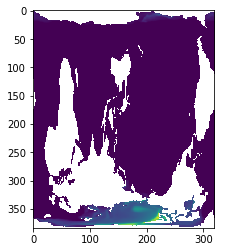

In [8]:
T = hi['TRUTH_24']
plt.imshow(T.hi.isel(time=0))

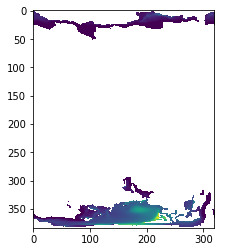

In [14]:
C = hi['FB_vol_noerr']
plt.imshow(C.hi.isel(time=0).where(C.hi.isel(time=0) > 0))

In [4]:
number  =15
gridlines = np.linspace(70, 280, 15)
gridline = gridlines[int(((len(gridlines)-1)/2)-(number-1)/2) : int(((len(gridlines)-1)/2)+(number-1)/2)+1]
gridline = [int(x) for x in gridline]


hi_truth_val = xr.open_dataset('/glade/work/mollyw/DART/observations/obs_converters/cice/data/hi_nc/mem_0024/perfect_thickness_4_15_err10.nc')
fb_truth_val = xr.open_dataset('/glade/work/mollyw/DART/observations/obs_converters/cice/data/fb_nc/mem_0024/perfect_freeboard_4_15_err01.nc')
itd_truth_val=xr.open_dataset('/glade/work/mollyw/DART/observations/obs_converters/cice/data/itd_nc/mem_0024/perfect_itd_4_15_err15.nc')

hi_val = hi_truth_val.where(hi_truth_val > 0).mean(dim = ['ni','nj'])
fb_val = fb_truth_val.mean(dim = ['ni','nj'])
itd_val = itd_truth_val.mean(dim = ['ni','nj'])


### Sea ice concentration

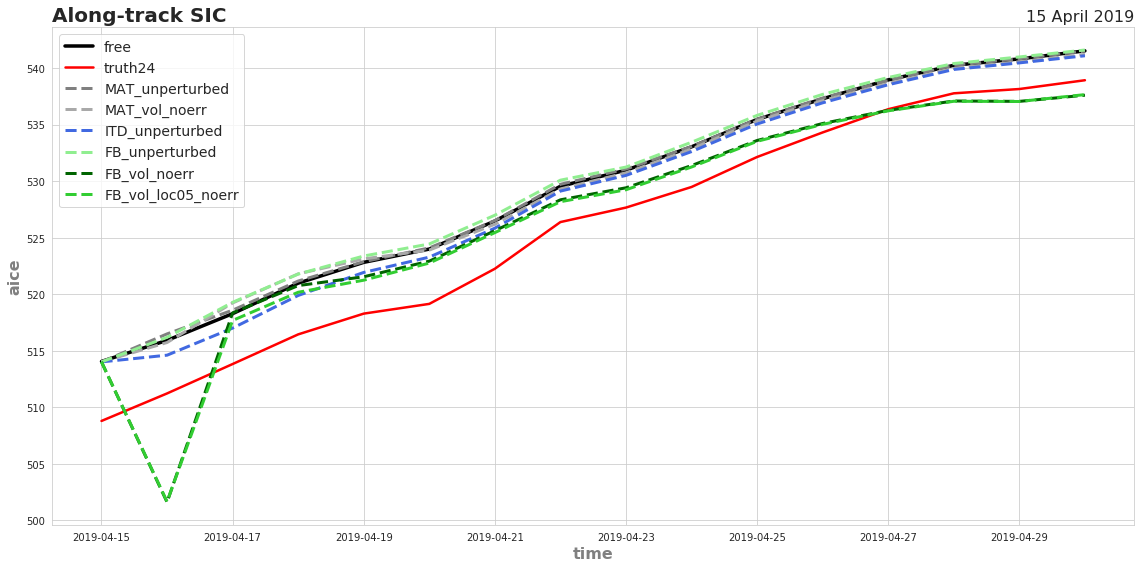

In [6]:
fig = plt.figure(figsize = (16,8)) 
seaborn.set_style("whitegrid")
seaborn.despine(left=True)
truths = ['24']
to_plot = aice['FREE'].aice.sel(ni = gridline)
plt.plot(aice['FREE'].time, aice['FREE'].aice.sel(ni = gridline).sum(dim=['ni','nj'], skipna=True), c = 'black', linewidth = 3.5, label= 'free')
count = 0
for t in truths:
    plt.plot(aice['TRUTH_{00}'.format(t)].time, aice['TRUTH_{00}'.format(t)].aice.sel(ni = gridline).sum(dim=['ni','nj']), c = t_colors[count], linewidth = 2.5, label= 'truth{00}'.format(t))
    count += 1
    
count = 0
for case in cases: 
    plt.plot(aice['FREE'].time, aice[case].aice.sel(ni = gridline).sum(dim=['ni','nj']), linestyle='dashed', c = colors[count],linewidth = 3, label= case)
    count += 1
    
plt.legend(fontsize = 14)
# plt.ylim([0.12, 0.122])
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)
plt.ylabel('aice', fontsize = 16, fontweight= 'bold', color = 'grey')
plt.xlabel('time', fontsize = 16, fontweight= 'bold', color = 'grey')
plt.grid(True)
plt.title(
    'Along-track SIC',
    fontweight='bold', fontsize=20, loc='left')
plt.title(date, fontsize=16, loc='right')

plt.tight_layout()

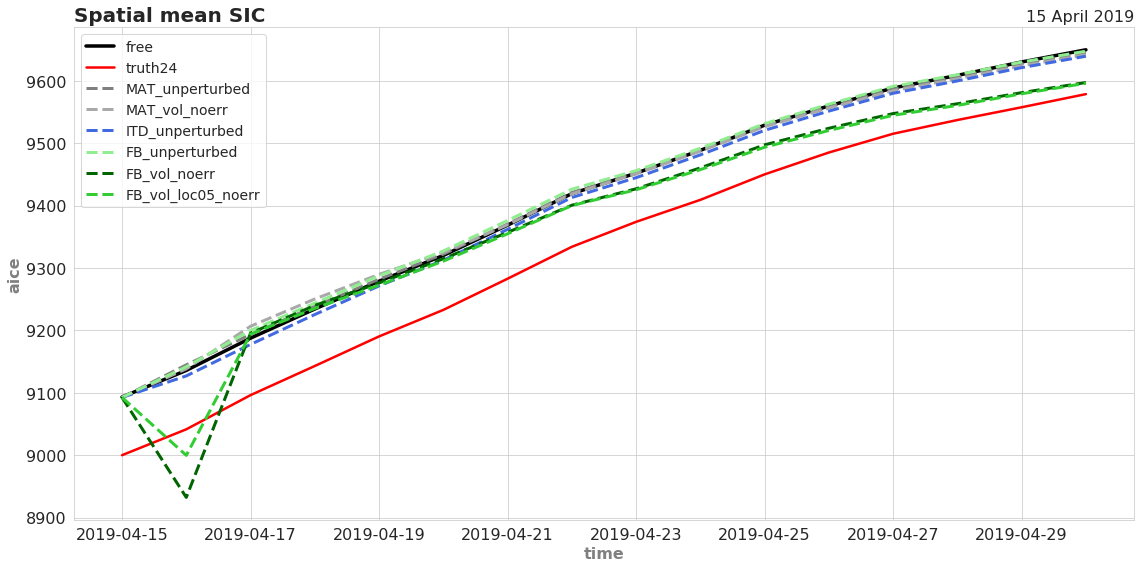

In [7]:
fig = plt.figure(figsize = (16,8)) 
seaborn.set_style("whitegrid")
seaborn.despine(left=True)

plt.plot(aice['FREE'].time, aice['FREE'].aice.sum(dim=['ni','nj']), c = 'black', linewidth = 3.5, label= 'free')
count = 0
for t in truths:
    plt.plot(aice['TRUTH_{00}'.format(t)].time, aice['TRUTH_{00}'.format(t)].aice.sum(dim=['ni','nj']), c = t_colors[count], linewidth = 2.5, label= 'truth{00}'.format(t))
    count += 1
    
count = 0
for case in cases: 
    plt.plot(aice['FREE'].time, aice[case].aice.sum(dim=['ni','nj']), linestyle='dashed', c = colors[count],linewidth = 3, label= case)
    count += 1
    
plt.legend(fontsize = 14)
# plt.ylim([0.12, 0.122])
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)
plt.ylabel('aice', fontsize = 16, fontweight= 'bold', color = 'grey')
plt.xlabel('time', fontsize = 16, fontweight= 'bold', color = 'grey')
plt.grid(True)
plt.title(
    'Spatial mean SIC',
    fontweight='bold', fontsize=20, loc='left')
plt.title(date, fontsize=16, loc='right')

plt.tight_layout()

### Sea ice thickness

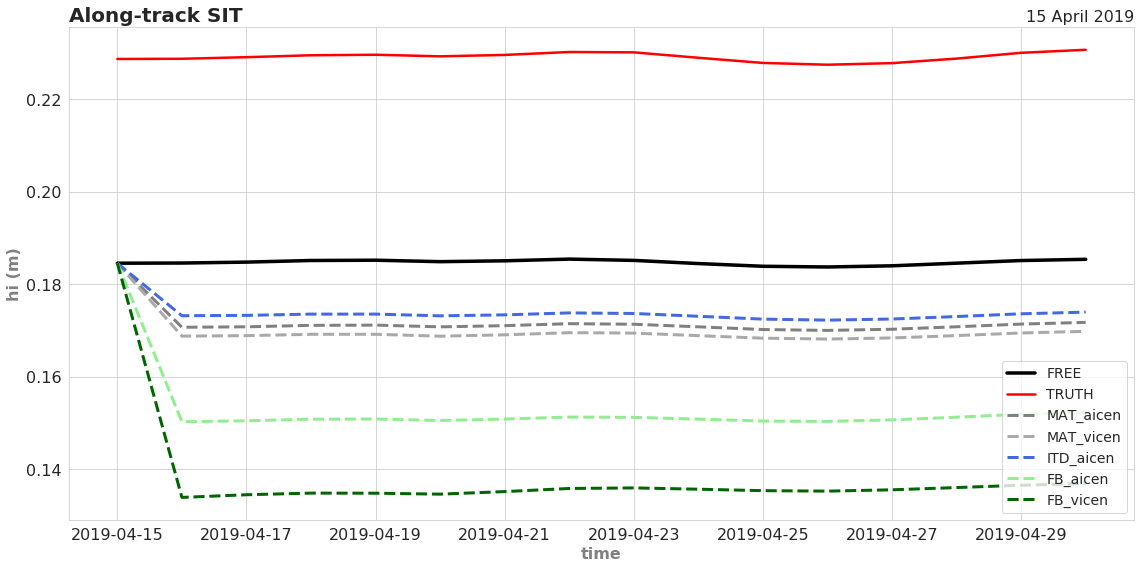

In [10]:
fig = plt.figure(figsize = (16,8)) 
seaborn.set_style("whitegrid")
seaborn.despine(left=True)
truths = ['24']
to_plot = vicen['FREE'].vicen.sel(ni = gridline)
plt.plot(vicen['FREE'].time, vicen['FREE'].vicen.sum(dim='nc').sel(ni = gridline).mean(dim=['ni','nj']), c = 'black', linewidth = 3.5, label= 'free')
count = 0
for t in truths:
    truth_plot = vicen['TRUTH_{00}'.format(t)].vicen.sum(dim='nc').sel(ni = gridline)
    plt.plot(vicen['TRUTH_{00}'.format(t)].time, vicen['TRUTH_{00}'.format(t)].hi.sel(ni = gridline).mean(dim=['ni','nj']), c = t_colors[count], linewidth = 2.5, label= 'truth{00}'.format(t))
    count += 1
    
count = 0
for case in cases: 
    case_plot = vicen[case].vicen.sel(ni = gridline)
    plt.plot(vicen['FREE'].time, vicen[case].vicen.sum(dim='nc').sel(ni = gridline).mean(dim=['ni','nj']), linestyle='dashed', c = colors[count],linewidth = 3, label= case)
    count += 1

# plt.fill_between(hi['FREE'].time.values, 
#                  hi['TRUTH_{00}'.format(t)].hi.sel(ni = gridline).mean(dim=['ni','nj']) + 0.1, 
#                  hi['TRUTH_{00}'.format(t)].hi.sel(ni = gridline).mean(dim=['ni','nj']) - 0.1, 
#                  facecolor = 'red',alpha = 0.1, label = 'perturbed env')

plt.legend(['FREE','TRUTH','MAT_aicen','MAT_vicen','ITD_aicen','FB_aicen','FB_vicen'],loc='lower right',fontsize = 14)
# plt.ylim([0.1, 0.4])
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)
plt.ylabel('hi (m)', fontsize = 16, fontweight= 'bold', color = 'grey')
plt.xlabel('time', fontsize = 16, fontweight= 'bold', color = 'grey')
plt.grid(True)
plt.title(
    'Along-track SIT',
    fontweight='bold', fontsize=20, loc='left')
plt.title(date, fontsize=16, loc='right')
plt.tight_layout()

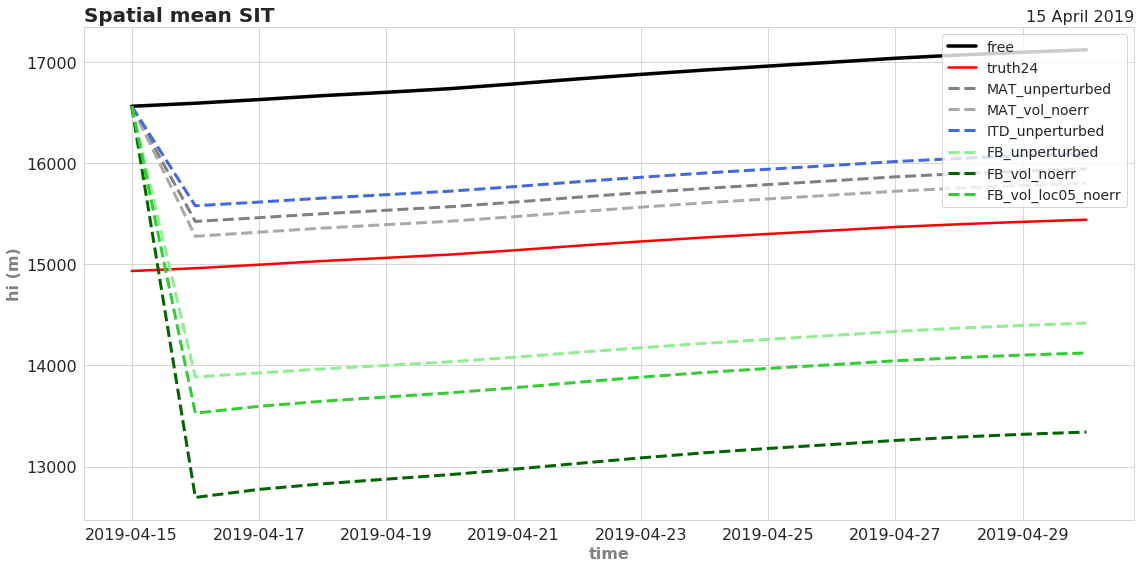

In [9]:
fig = plt.figure(figsize = (16,8)) 
seaborn.set_style("whitegrid")
seaborn.despine(left=True)

plt.plot(hi['FREE'].time, hi['FREE'].hi.sum(dim=['ni','nj']), c = 'black', linewidth = 3.5, label= 'free')
count = 0
for t in truths:
    plt.plot(hi['TRUTH_{00}'.format(t)].time, hi['TRUTH_{00}'.format(t)].hi.sum(dim=['ni','nj']), c = t_colors[count], linewidth = 2.5, label= 'truth{00}'.format(t))
    count += 1

count = 0
for case in cases: 
    plt.plot(hi['FREE'].time, hi[case].hi.sum(dim=['ni','nj']), linestyle='dashed', c = colors[count],linewidth = 3, label= case)
    count += 1
    
plt.legend(loc='upper right',fontsize = 14)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)
plt.ylabel('hi (m)', fontsize = 16, fontweight= 'bold', color = 'grey')
plt.xlabel('time', fontsize = 16, fontweight= 'bold', color = 'grey')
plt.grid(True)
plt.title(
    'Spatial mean SIT',
    fontweight='bold', fontsize=20, loc='left')
plt.title(date, fontsize=16, loc='right')
plt.tight_layout()

### Sea ice thickness distribution

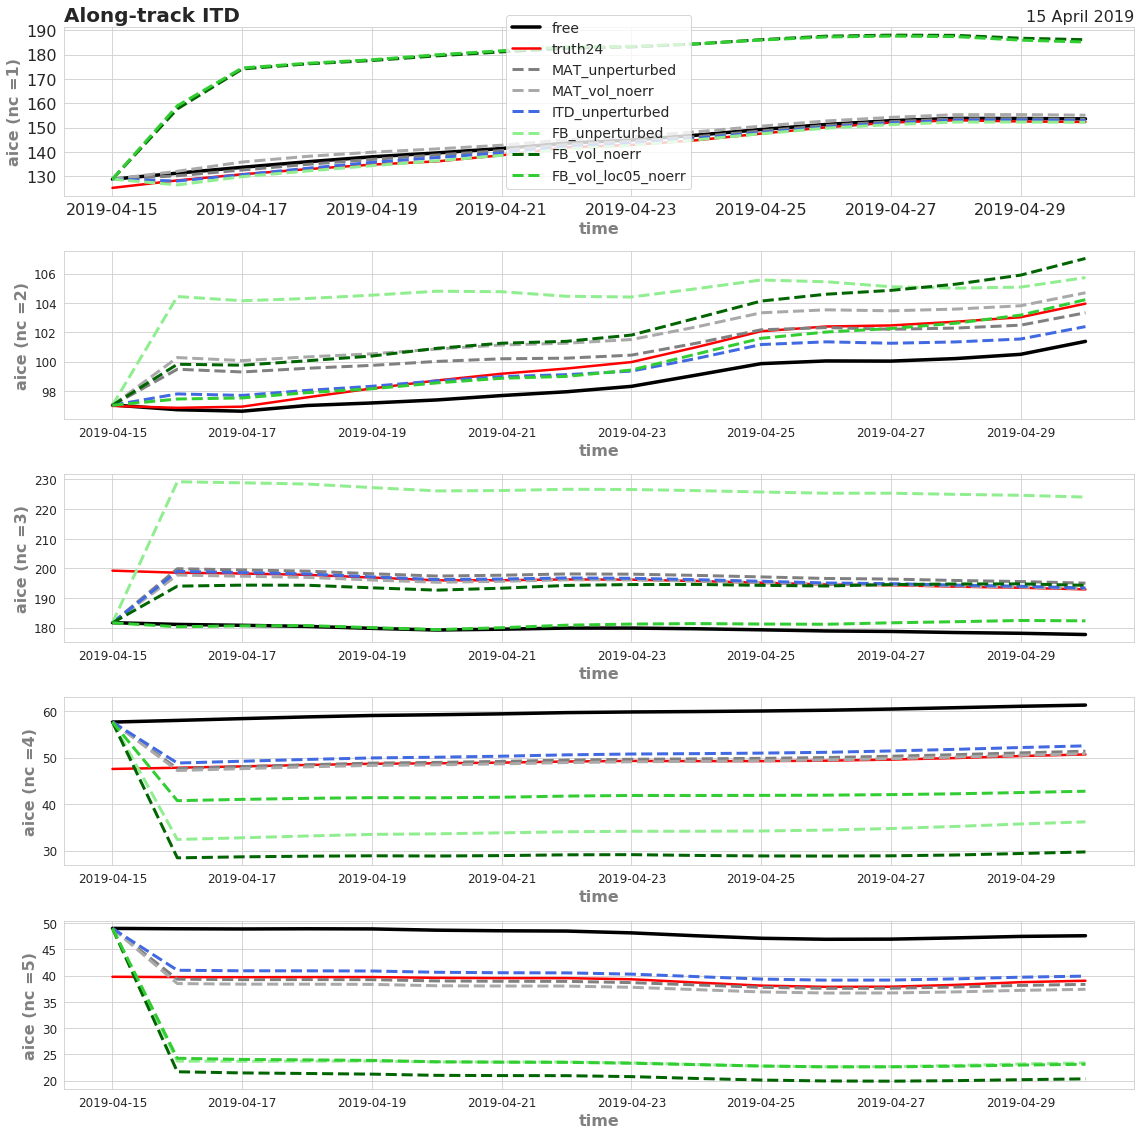

In [10]:
fig = plt.figure(figsize = (16,16)) 
seaborn.set_style("whitegrid")
seaborn.despine(left=True)
nrows = 5

for i in range(0,5):
    ax = fig.add_subplot(nrows, 1, i+1) #np.floor(len(cases)/3),
    
    ax.plot(aicen['FREE'].time, aicen['FREE'].aicen.sel(nc = i).sel(ni = gridline).sum(dim=['ni','nj']), c = 'black', linewidth = 3.5, label= 'free')
    count1 = 0
    for t in truths:
        ax.plot(aicen['TRUTH_{00}'.format(t)].time, aicen['TRUTH_{00}'.format(t)].aicen.sel(nc = i).sel(ni = gridline).sum(dim=['ni','nj']), c = t_colors[0], linewidth = 2.5, label= 'truth{00}'.format(t))
        count1 += 1
        
    count = 0
    for case in cases: 
        ax.plot(aicen['FREE'].time, aicen[case].aicen.sel(nc = i).sel(ni = gridline).sum(dim=['ni','nj']), linestyle='dashed', c = colors[count],linewidth = 3, label= case)
        count += 1
    
    if i == 0:
        plt.legend(fontsize = 14)
        plt.title(
                    'Along-track ITD',
                    fontweight='bold', fontsize=20, loc='left')
        plt.title(date, fontsize=16, loc='right')
        
# plt.ylim([0.12, 0.122])
    matplotlib.rc('xtick', labelsize=12) 
    matplotlib.rc('ytick', labelsize=12)
    plt.ylabel('aice (nc =' + str(i+1) + ')', fontsize = 16, fontweight= 'bold', color = 'grey')
    plt.xlabel('time', fontsize = 16, fontweight= 'bold', color = 'grey')
    plt.grid(True)

plt.tight_layout()

### Sea ice volume distribution

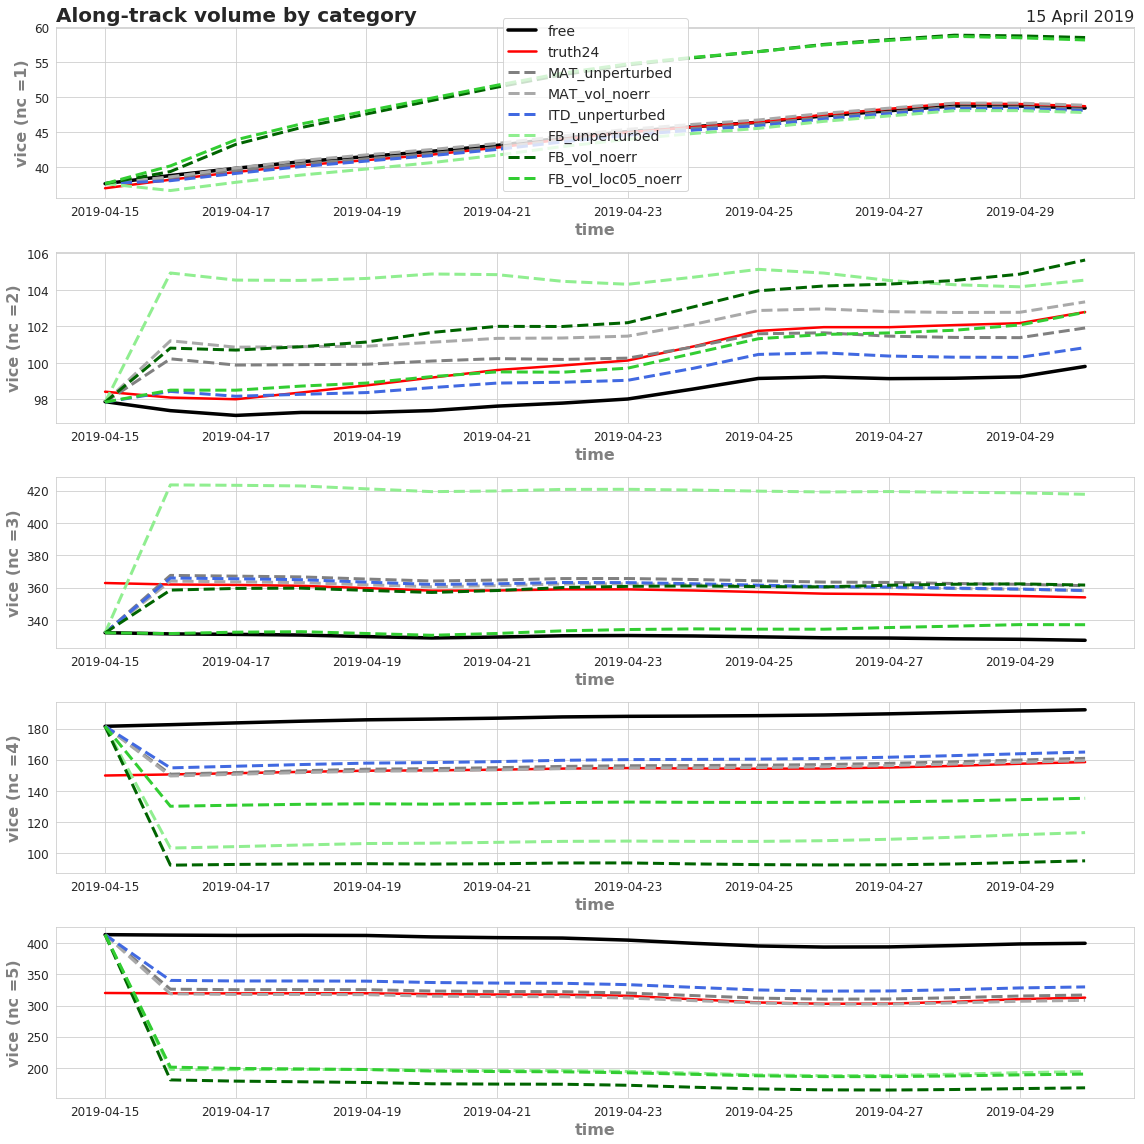

In [11]:
fig = plt.figure(figsize = (16,16)) 
seaborn.set_style("whitegrid")
seaborn.despine(left=True)

nrows = 5

for i in range(0,5):
    ax = fig.add_subplot(nrows, 1, i+1) #np.floor(len(cases)/3),
    
    ax.plot(vicen['FREE'].time, vicen['FREE'].vicen.sel(nc = i).sel(ni = gridline).sum(dim=['ni','nj']), c = 'black', linewidth = 3.5, label= 'free')
    count1 = 0
    for t in truths:
        ax.plot(vicen['TRUTH_{00}'.format(t)].time, vicen['TRUTH_{00}'.format(t)].vicen.sel(nc = i).sel(ni = gridline).sum(dim=['ni','nj']), c = t_colors[count1], linewidth = 2.5, label= 'truth{00}'.format(t))
        count1 += 1
        
    count = 0
    for case in cases: 
        ax.plot(vicen['FREE'].time, vicen[case].vicen.sel(nc = i).sel(ni = gridline).sum(dim=['ni','nj']), linestyle='dashed', c = colors[count],linewidth = 3, label= case)
        count += 1
    
    if i == 0:
        plt.legend(fontsize = 14)
        plt.title(
                    'Along-track volume by category',
                    fontweight='bold', fontsize=20, loc='left')
        plt.title(date, fontsize=16, loc='right')
        
# plt.ylim([0.12, 0.122])
    matplotlib.rc('xtick', labelsize=12) 
    matplotlib.rc('ytick', labelsize=12)
    plt.ylabel('vice (nc =' + str(i+1) + ')', fontsize = 16, fontweight= 'bold', color = 'grey')
    plt.xlabel('time', fontsize = 16, fontweight= 'bold', color = 'grey')
    plt.grid(True)

plt.tight_layout()

### Sea ice snow distribution

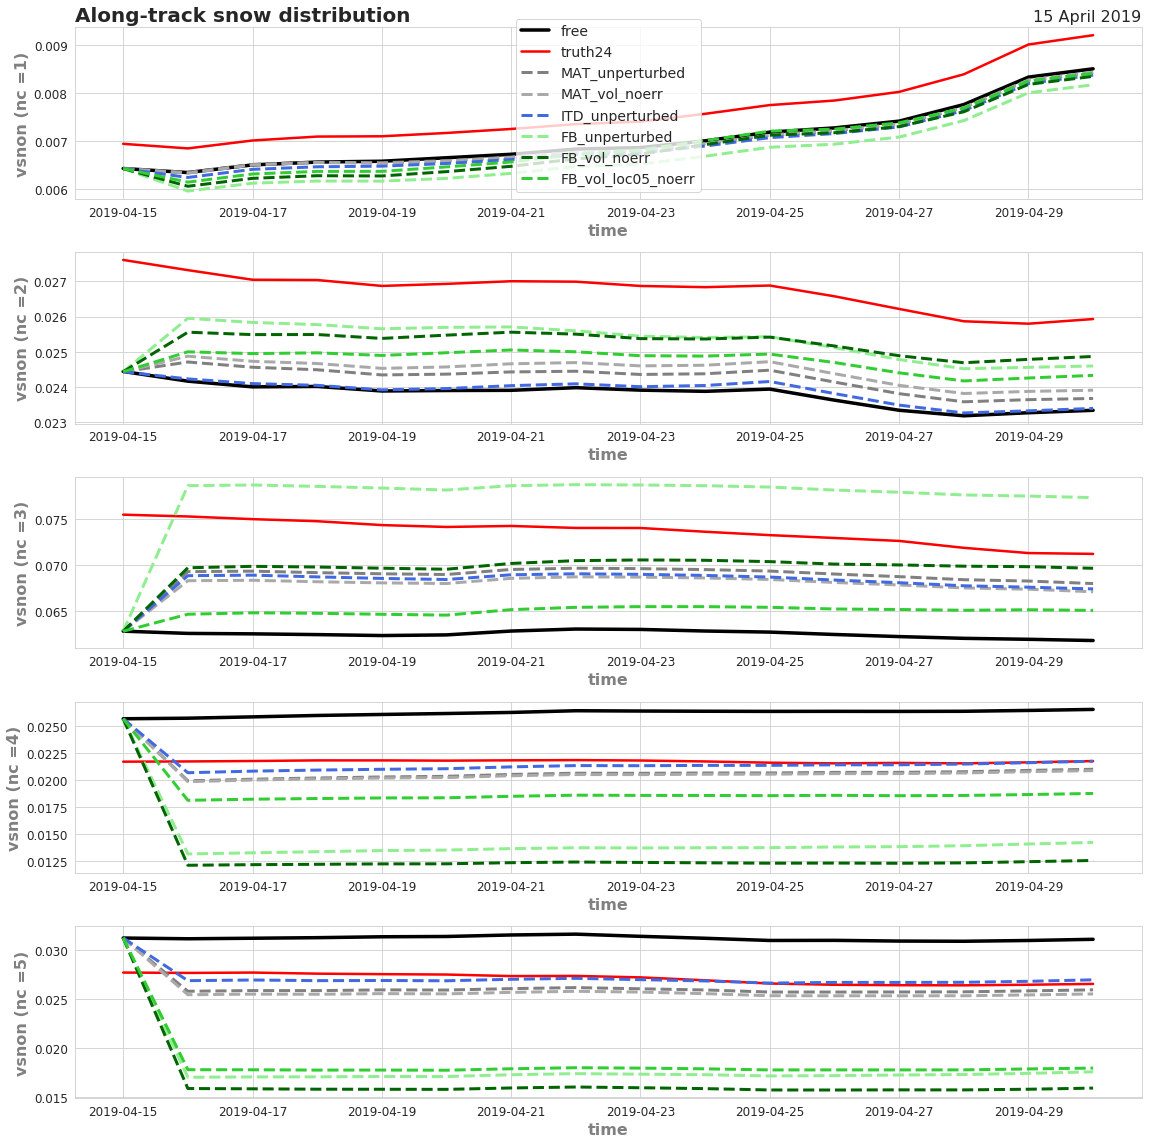

In [11]:
fig = plt.figure(figsize = (16,16)) 
seaborn.set_style("whitegrid")
seaborn.despine(left=True)

nrows = 5

for i in range(0,5):
    ax = fig.add_subplot(nrows, 1, i+1) #np.floor(len(cases)/3),
    
    ax.plot(vsnon['FREE'].time, vsnon['FREE'].vsnon.sel(nc = i).sel(ni = gridline).mean(dim=['ni','nj']), c = 'black', linewidth = 3.5, label= 'free')
    count = 0
    for t in truths:
        ax.plot(vsnon['TRUTH_{00}'.format(t)].time, vsnon['TRUTH_{00}'.format(t)].vsnon.sel(nc = i).sel(ni = gridline).mean(dim=['ni','nj']), c = t_colors[count], linewidth = 2.5, label= 'truth{00}'.format(t))
        count += 1
    count = 0
    
    for case in cases: 
        ax.plot(vsnon['FREE'].time, vsnon[case].vsnon.sel(nc = i).sel(ni = gridline).mean(dim=['ni','nj']), linestyle='dashed', c = colors[count],linewidth = 3, label= case)
        count += 1
    
    if i == 0:
        plt.legend(fontsize = 14)
        plt.title(
                    'Along-track snow distribution',
                    fontweight='bold', fontsize=20, loc='left')
        plt.title(date, fontsize=16, loc='right')
        
# plt.ylim([0.12, 0.122])
    matplotlib.rc('xtick', labelsize=12) 
    matplotlib.rc('ytick', labelsize=12)
    plt.ylabel('vsnon (nc =' + str(i+1) + ')', fontsize = 16, fontweight= 'bold', color = 'grey')
    plt.xlabel('time', fontsize = 16, fontweight= 'bold', color = 'grey')
    plt.grid(True)

plt.tight_layout()

In [12]:
c_vicen = vicen['FB_unperturbed']
c_vsnon = vsnon['FB_unperturbed']
c_aicen = aicen['FB_unperturbed']


# set up constants (same values as DART)
ice_dens   =  917.0
snow_dens  =  330.0
water_dens = 1026.0
    
    # isolate aice, vsno, vice by category 
vice_volume = c_vicen.vicen
snow_volume = c_vsnon.vsnon
aice_volume = c_aicen.aicen.sum(dim = 'nc')
    
    # calculate agregate freeboard and concentration
for i in range(0,5):
        #(from DART code obs_def_cice_mod.f90)
    print(i)
    fb_volume =+ (vice_volume.sel(nc=i)*(1 - ice_dens/water_dens) - snow_volume.sel(nc=i)*snow_dens/water_dens)#/aice_volume.sel(nc =i).max()
    
fb_agreg = fb_volume.where(aice_volume > 1e-6)/aice_volume.where(aice_volume > 1e-6)

0
1
2
3
4


In [13]:
t_vicen = vicen['TRUTH_24']
t_vsnon = vsnon['TRUTH_24']
t_aicen = aicen['TRUTH_24']

f_vicen = vicen['FREE']
f_vsnon = vsnon['FREE']
f_aicen = aicen['FREE']

    
    # isolate aice, vsno, vice by category 
tvice_volume = t_vicen.vicen
tsnow_volume = t_vsnon.vsnon
taice_volume = t_aicen.aicen.sum(dim = 'nc')

fvice_volume = f_vicen.vicen
fsnow_volume = f_vsnon.vsnon
faice_volume = f_aicen.aicen.sum(dim = 'nc')

    
# calculate agregate freeboard and concentration
for i in range(0,5):
        #(from DART code obs_def_cice_mod.f90)
    print(i)
    tfb_volume =+ (tvice_volume.sel(nc=i)*(1 - ice_dens/water_dens) - tsnow_volume.sel(nc=i)*snow_dens/water_dens)
    ffb_volume =+ (fvice_volume.sel(nc=i)*(1 - ice_dens/water_dens) - fsnow_volume.sel(nc=i)*snow_dens/water_dens)#/aice_volume.sel(nc =i).max()
    
    tfb_agreg = tfb_volume.where(taice_volume > 1e-6)/taice_volume.where(taice_volume > 1e-6)
    ffb_agreg = ffb_volume.where(faice_volume > 1e-6)/faice_volume.where(faice_volume > 1e-6)

0
1
2
3
4


In [31]:
dev_ffb = ffb_agreg.isel(time=0)-ffb_agreg.mean(dim = ['ni','nj']).isel(time=0)
dev_fhi = hi['FREE'].hi.isel(time=0) - hi['FREE'].hi.mean(dim = ['ni','nj']).isel(time=0)

# cov = dev_tfb @ dev_thi
print(dev_ffb.shape)
print(dev_fhi.shape)

cov = np.multiply(dev_fhi,dev_fhi)

(384, 320)
(384, 320)


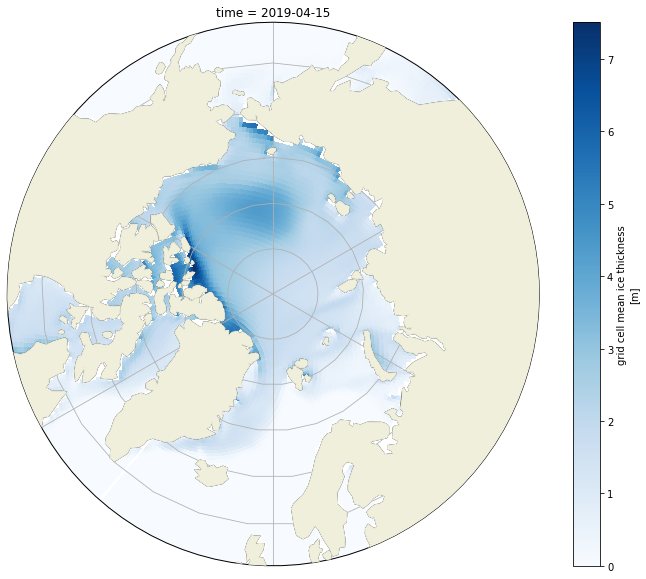

In [42]:
f=plt.figure(figsize=(12,10))

onPOPgrid=hi['FB_unperturbed'].hi.isel(time=0) #- hi['FB_unperturbed'].hi.isel(time=1)
grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')
    
onPOPgrid.ULAT[:]=grid.lat
onPOPgrid.ULON[:]=grid.lon
#     onPOP1D=onPOPgrid.stack(n_s=('nj','ni'))
#     ongrid2=numpy.zeros(Ntot)
#     ongrid2[dst]=numpy.multiply(Tr.S.values,onPOP1D[src].values)
#     with numpy.errstate(divide='ignore', invalid='ignore'):
#         ongrid2=numpy.divide(ongrid2,totwts)
#     onPMgrid=numpy.reshape(ongrid2,(Tr.dst_grid_dims[1].values,Tr.dst_grid_dims[0].values))
    
    
#     tmp=numpy.flipud(onPMgrid.T)
#     # the land is nan which by default has color of zero so change it to a large negative 
#     tmp[numpy.isnan(tmp)]=-999.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

ax=plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=6)
    
onPOPgrid.plot.pcolormesh('ULON', 'ULAT', ax=ax, transform=ccrs.PlateCarree(), cmap=plt.cm.Blues) #vmax = 0.05,
#     hnd=plt.pcolor(tmp, vmin=-.2, vmax=.2, cmap=plt.cm.seismic)
#     plt.ylim([110, 330])
# xr.plot.scatter(track, x = 'lon', y = 'lat', c = 'k', transform = ccrs.PlateCarree())  # vmin = 0, vmax = 0.1,
# xr.plot.scatter(track_ni200, x = 'lon', y = 'lat', c = 'k',  transform = ccrs.PlateCarree())
# xr.plot.scatter(track_circle, x = 'lon', y = 'lat', c = 'k', transform = ccrs.PlateCarree())
# plt.title('MB, Localization = 0.1')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False,labelleft=False) # labels along the bottom edge are off
# plt.suptitle('Fall Mean SIT Bias, FREE vs Mem24',fontsize =16)
# plt.tight_layout()
   

/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)


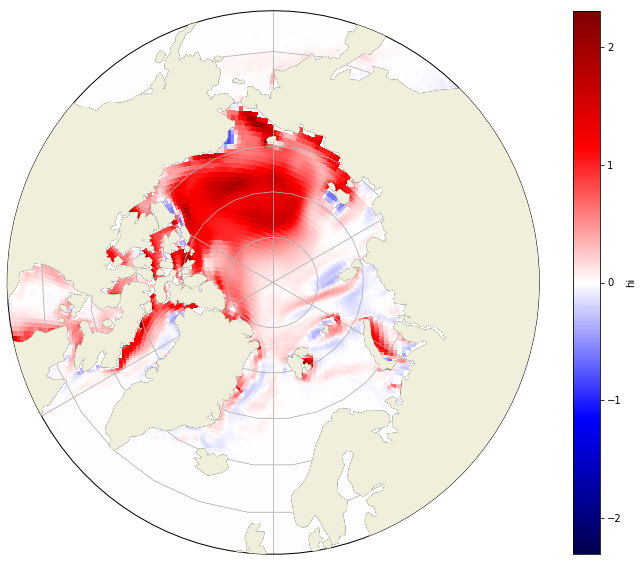

In [43]:
f=plt.figure(figsize=(12,10))

onPOPgrid=hi['FB_unperturbed'].hi.isel(time=0) - hi['FB_unperturbed'].hi.isel(time=1)
grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')
    
onPOPgrid.ULAT[:]=grid.lat
onPOPgrid.ULON[:]=grid.lon
#     onPOP1D=onPOPgrid.stack(n_s=('nj','ni'))
#     ongrid2=numpy.zeros(Ntot)
#     ongrid2[dst]=numpy.multiply(Tr.S.values,onPOP1D[src].values)
#     with numpy.errstate(divide='ignore', invalid='ignore'):
#         ongrid2=numpy.divide(ongrid2,totwts)
#     onPMgrid=numpy.reshape(ongrid2,(Tr.dst_grid_dims[1].values,Tr.dst_grid_dims[0].values))
    
    
#     tmp=numpy.flipud(onPMgrid.T)
#     # the land is nan which by default has color of zero so change it to a large negative 
#     tmp[numpy.isnan(tmp)]=-999.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

ax=plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=6)
    
onPOPgrid.plot.pcolormesh('ULON', 'ULAT', ax=ax, transform=ccrs.PlateCarree(), cmap=plt.cm.seismic) #vmax = 0.05,
#     hnd=plt.pcolor(tmp, vmin=-.2, vmax=.2, cmap=plt.cm.seismic)
#     plt.ylim([110, 330])
# xr.plot.scatter(track, x = 'lon', y = 'lat', c = 'k', transform = ccrs.PlateCarree())  # vmin = 0, vmax = 0.1,
# xr.plot.scatter(track_ni200, x = 'lon', y = 'lat', c = 'k',  transform = ccrs.PlateCarree())
# xr.plot.scatter(track_circle, x = 'lon', y = 'lat', c = 'k', transform = ccrs.PlateCarree())
# plt.title('MB, Localization = 0.1')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False,labelleft=False) # labels along the bottom edge are off
# plt.suptitle('Fall Mean SIT Bias, FREE vs Mem24',fontsize =16)
# plt.tight_layout()
   

## MAB Figures

### Sea ice concentration

/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)


ValueError: num must be 1 <= num <= 4, not 5

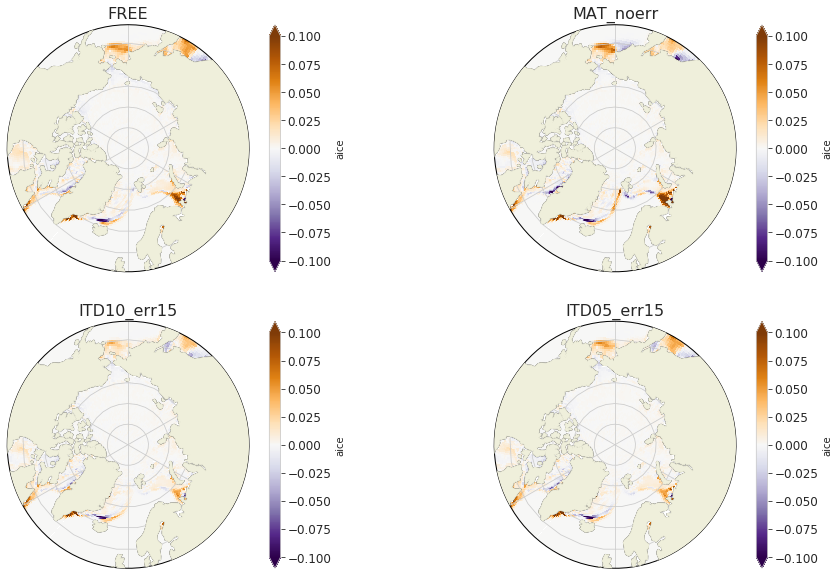

In [10]:
f = plt.figure(figsize=(16,10))

nrows = 2
# fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)
# axs = axs.ravel()


grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

ax = f.add_subplot(nrows, np.ceil(len(cases)/nrows), 1, projection=ccrs.NorthPolarStereo()) #np.floor(len(cases)/2)

onPOPgrid_free = sum((aice['FREE'].aice - aice['TRUTH'].aice))/len(aice['TRUTH'].aice)
onPOPgrid_free.ULAT[:]=grid.lat
onPOPgrid_free.ULON[:]=grid.lon

ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=6)
    
onPOPgrid_free.plot.pcolormesh('ULON', 'ULAT',vmin = -0.1, vmax = 0.1, transform=ccrs.PlateCarree(), cmap=plt.cm.PuOr_r) #vmax = 0.05,
ax.set_title("FREE", fontsize = 16)

count = 0
for case in cases:
    
    ax = f.add_subplot(nrows, np.ceil(len(cases)/nrows), count+2, projection=ccrs.NorthPolarStereo()) #np.floor(len(cases)/3),
    
    onPOPgrid = sum((aice[case].aice - aice['TRUTH'].aice))/len(aice['TRUTH'].aice)
    onPOPgrid.ULAT[:]=grid.lat
    onPOPgrid.ULON[:]=grid.lon
    
    obj = onPOPgrid #onPOPgrid_free - onPOPgrid
    
    ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
    ax.gridlines()
    ax.coastlines()
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.LAND,zorder=6)
    
    obj.plot.pcolormesh('ULON', 'ULAT', vmin = -0.1, vmax = 0.1, transform=ccrs.PlateCarree(), cmap=plt.cm.PuOr_r) #vmax = 0.05,
    
    ax.set_title(case, fontsize = 16)
    
    count += 1

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False,labelleft=False) # labels along the bottom edge are off
plt.suptitle('Mean Absolute Bias, SIC', y=1.08, fontsize = 20, fontweight= 'bold')
plt.tight_layout()

### Sea ice thickness

In [ ]:
f = plt.figure(figsize=(16,10))

grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

ax = f.add_subplot(nrows, np.ceil(len(cases)/nrows), 1, projection=ccrs.NorthPolarStereo())

onPOPgrid_free = sum((hi['FREE'].hi - hi['TRUTH'].hi))/len(hi['TRUTH'].hi)
onPOPgrid_free.ULAT[:]=grid.lat
onPOPgrid_free.ULON[:]=grid.lon

ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=6)

onPOPgrid_free.plot.pcolormesh('ULON', 'ULAT', vmin = -1, vmax = 1, transform=ccrs.PlateCarree(), cmap=plt.cm.PuOr_r) #vmax = 0.05,

ax.set_title("FREE", fontsize = 16)

count = 0
for case in cases:
    
    ax = f.add_subplot(nrows, np.ceil(len(cases)/nrows), count+2, projection=ccrs.NorthPolarStereo())
    
    onPOPgrid = sum((hi[case].hi - hi['TRUTH'].hi))/len(aice['TRUTH'].hi)
    onPOPgrid.ULAT[:]=grid.lat
    onPOPgrid.ULON[:]=grid.lon
    
    obj = onPOPgrid #onPOPgrid_free - onPOPgrid
    
    ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
    ax.gridlines()
    ax.coastlines()
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.LAND,zorder=6)
    
    obj.plot.pcolormesh('ULON', 'ULAT', vmin = -1, vmax = 1, transform=ccrs.PlateCarree(), cmap=plt.cm.PuOr_r) #vmax = 0.05,
    
    ax.set_title(case, fontsize = 16)
    
    count += 1

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False,labelleft=False) # labels along the bottom edge are off
plt.suptitle('Mean Absolute Bias, SIT', y=1.08, fontsize = 20, fontweight= 'bold')
plt.tight_layout()

## RMSE Figures

### Sea ice concentration

In [9]:
free.max()

FileNotFoundError: [Errno 2] No such file or directory: b'/glade/scratch/mollyw/archive/free30/ice/proc/tseries/day_1/free30.cice.h.hi.20150101-20200608.nc'

In [7]:
t = 15 
free = aice['FREE'].aice.isel(time=slice(0,t)).load()
true = aice['TRUTH'].aice.isel(time=slice(0,t)).load()
norms = len(aice['TRUTH'].time[0:i]).load()

no_assim =  np.sqrt(sum((free - true)**2)/norms)


FileNotFoundError: [Errno 2] No such file or directory: b'/glade/scratch/mollyw/archive/free30/ice/proc/tseries/day_1/free30.cice.h.aice.20150101-20200608.nc'

/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)


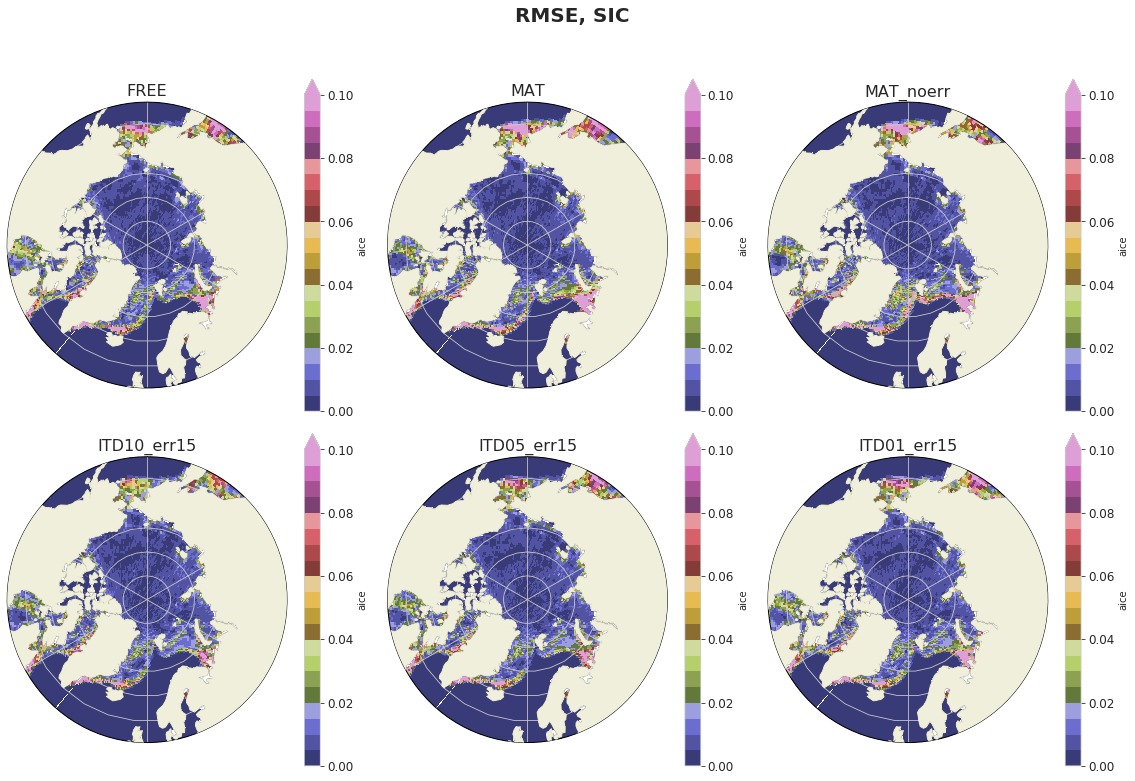

In [148]:
f = plt.figure(figsize=(16,10))

grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

ax = f.add_subplot(nrows, np.ceil(len(cases)/nrows), 1, projection=ccrs.NorthPolarStereo())

onPOPgrid_free = no_assim
onPOPgrid_free.ULAT[:]=grid.lat
onPOPgrid_free.ULON[:]=grid.lon

ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=6)

onPOPgrid_free.plot.pcolormesh('ULON', 'ULAT',vmin = 0, vmax= 0.1, transform=ccrs.PlateCarree(), cmap=plt.cm.tab20b) #vmax = 0.05,

ax.set_title("FREE", fontsize = 16)

count = 0
for case in cases:
    
    ax = f.add_subplot(nrows, np.ceil(len(cases)/nrows), count+2, projection=ccrs.NorthPolarStereo())
    thing = aice[case].aice.isel(time=slice(0,t))
    
    onPOPgrid = np.sqrt(sum((thing - true)**2)/norms)
    onPOPgrid.ULAT[:]=grid.lat
    onPOPgrid.ULON[:]=grid.lon
    
    obj = onPOPgrid
    
    ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
    ax.gridlines()
    ax.coastlines()
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.LAND,zorder=6)
    
    obj.plot.pcolormesh('ULON', 'ULAT', vmin = 0, vmax= 0.1, transform=ccrs.PlateCarree(), cmap=plt.cm.tab20b) #vmax = 0.05,
    
    ax.set_title(case, fontsize = 16)
    
    count += 1

plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelbottom=False,labelleft=False) # labels along the bottom edge are off
plt.suptitle('RMSE, SIC', y=1.08, fontsize = 20, fontweight= 'bold')
plt.tight_layout()

### Sea ice thickness distribution

In [ ]:
f = plt.figure(figsize=(16,3))

grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

ax = f.add_subplot(nrows, np.ceil(len(cases)/nrows), 1, projection=ccrs.NorthPolarStereo())

norms = len(aicen['TRUTH'].time[0:15])

count = 0
for case in ['MAT']: #cases:
    
    for i in range(0,5):
    
        ax = f.add_subplot(nrows, np.ceil(len(cases)/nrows), count+1, projection=ccrs.NorthPolarStereo())
        true = aicen['TRUTH'].aicen.sel(nc=i).isel(time=slice(0,15))
        thing = aicen[case].aicen.sel(nc=i).isel(time=slice(0,15))
    
        onPOPgrid = np.sqrt(sum((thing - true)**2)/norms)
        onPOPgrid.ULAT[:]=grid.lat
        onPOPgrid.ULON[:]=grid.lon
    
        obj = onPOPgrid
    
        ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
        ax.gridlines()
        ax.coastlines()
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.add_feature(cfeature.LAND,zorder=6)
    
        obj.plot.pcolormesh('ULON', 'ULAT', vmin = 0, vmax= 0.1, transform=ccrs.PlateCarree(), cmap=plt.cm.tab20b) #vmax = 0.05,
    
        ax.set_title('nc = '+ str(i+1), fontsize = 16)
    
        count += 1

    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelbottom=False,labelleft=False) # labels along the bottom edge are off
plt.suptitle('RMSE, '+ case + ' SIC', y=1.08, fontsize = 20, fontweight= 'bold')
plt.tight_layout()

### Sea ice thickness

In [5]:
free = hi['FREE'].hi.isel(time=slice(0,15))
true = hi['TRUTH'].hi.isel(time=slice(0,15))
norms = len(hi['TRUTH'].time[0:15])

no_assim =  np.sqrt(sum((free - true)**2)/norms)

FileNotFoundError: [Errno 2] No such file or directory: b'/glade/scratch/mollyw/archive/free30/ice/proc/tseries/day_1/free30.cice.h.hi.20150101-20200608.nc'

/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)


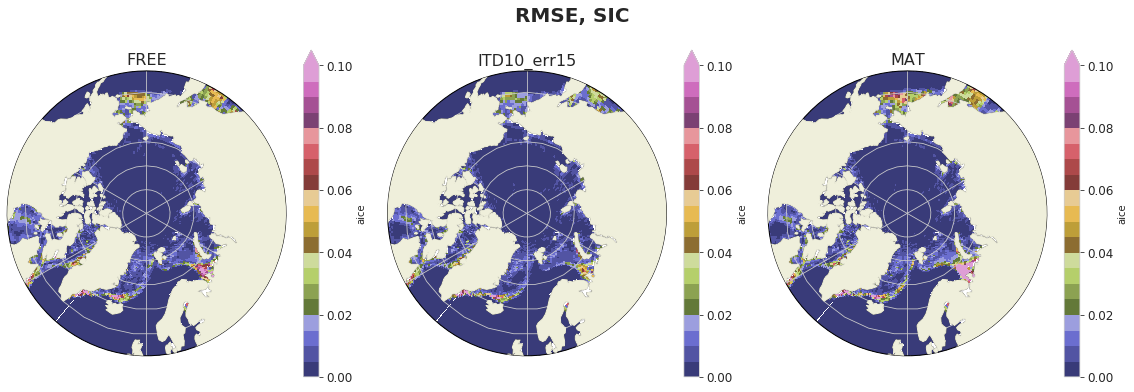

In [142]:
f = plt.figure(figsize=(16,5))

grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

ax = f.add_subplot(nrows, np.ceil(len(cases)/nrows), 1, projection=ccrs.NorthPolarStereo())



onPOPgrid_free = no_assim
onPOPgrid_free.ULAT[:]=grid.lat
onPOPgrid_free.ULON[:]=grid.lon

ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=6)

onPOPgrid_free.plot.pcolormesh('ULON', 'ULAT', vmin = 0, vmax  = 0.1, transform=ccrs.PlateCarree(), cmap=plt.cm.tab20b) #vmax = 0.05,

ax.set_title("FREE", fontsize = 16)

count = 0
for case in cases:
    
    ax = f.add_subplot(nrows, np.ceil(len(cases)/nrows), count+2, projection=ccrs.NorthPolarStereo())
    
    thing = hi[case].hi.isel(time=slice(0,15))
    
    onPOPgrid = np.sqrt(sum((thing - true)**2)/norms)
    onPOPgrid.ULAT[:]=grid.lat
    onPOPgrid.ULON[:]=grid.lon
    
    obj = onPOPgrid
    
    ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
    ax.gridlines()
    ax.coastlines()
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.LAND,zorder=6)
    
    obj.plot.pcolormesh('ULON', 'ULAT', vmin = 0, vmax = 0.1, transform=ccrs.PlateCarree(), cmap=plt.cm.tab20b) #vmax = 0.05,
    
    ax.set_title(case, fontsize = 16)
    
    count += 1

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False,labelleft=False) # labels along the bottom edge are off
plt.suptitle('RMSE, SIC', y=1.08, fontsize = 20, fontweight= 'bold')
plt.tight_layout()

In [24]:
# ds_grid1= EXPERIMENT1["GRID1"]
# ds_grid3 = EXPERIMENT1["GRID3"]
# ds_grid7 = EXPERIMENT1["GRID7"]
ds_MAT = EXPERIMENT1["DFLT"]
ds_ITD = EXPERIMENT1["DFLT_ITD"]
ds_aITD = EXPERIMENT1["AICEN_ITD"]
ds_aITD01 = EXPERIMENT1["AICEN_ITD01"]
# ds_grid15 = EXPERIMENT1["GRID15"]
# ds_itd15 = EXPERIMENT1["ITD15"]
# ds_grid15e1 = EXPERIMENT1["GRIDe1"]
# ds_itd15e1 = EXPERIMENT1["ITDe1"]
# ds_grid15e2 = EXPERIMENT1["GRIDe2"]
# ds_itd15e2 = EXPERIMENT1["ITDe2"]
# ds_itd15conc = EXPERIMENT1["ITD_CONC"]
# ds_spring15 = EXPERIMENT1['SPRING15']
ds_free = EXPERIMENT1["FREE"]
# ds_truth = EXPERIMENT1["TRUTH"]
ds_truth = EXPERIMENT1["TRUTH"]

In [25]:
# ds_itd15.load()
# ds_grid15.load()
# ds_grid15e1.load()
# ds_itd15e1.load()
# ds_grid15e2.load()
# ds_itd15e2.load()
# ds_itd15conc.load()
ds_MAT.load()
ds_ITD.load()
ds_aITD.load()

<xarray.Dataset>
Dimensions:      (d2: 2, nc: 5, ni: 320, nj: 384, nkbio: 5, nkice: 8, nksnow: 3, nvertices: 4, time: 16)
Coordinates:
    TLON         (nj, ni) float32 320.5625 321.6875 ... 319.35068 319.7835
    TLAT         (nj, ni) float32 -79.22052 -79.22052 ... 72.18933 72.185974
    ULON         (nj, ni) float32 321.125 322.25 323.375 ... 319.58603 320.0
    ULAT         (nj, ni) float32 -78.952896 -78.952896 ... 72.41355 72.411934
  * time         (time) datetime64[ns] 2019-04-15 2019-04-16 ... 2019-04-30
Dimensions without coordinates: d2, nc, ni, nj, nkbio, nkice, nksnow, nvertices
Data variables:
    NCAT         (nc) float32 0.6445072 1.3914335 2.4701793 4.567288 100000000.0
    VGRDi        (nkice) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
    VGRDs        (nksnow) float32 1.0 2.0 3.0
    VGRDb        (nkbio) float32 1.0 2.0 3.0 4.0 5.0
    tmask        (nj, ni) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    tarea        (nj, ni) float32 1423619100.0 1423619100.0 ..

In [7]:
ds_free.load()

<xarray.Dataset>
Dimensions:      (d2: 2, nc: 5, ni: 320, nj: 384, nkbio: 5, nkice: 8, nksnow: 3, nvertices: 4, time: 16)
Coordinates:
    TLON         (nj, ni) float32 320.5625 321.6875 ... 319.35068 319.7835
    TLAT         (nj, ni) float32 -79.22052 -79.22052 ... 72.18933 72.185974
    ULON         (nj, ni) float32 321.125 322.25 323.375 ... 319.58603 320.0
    ULAT         (nj, ni) float32 -78.952896 -78.952896 ... 72.41355 72.411934
  * time         (time) datetime64[ns] 2019-04-15 2019-04-16 ... 2019-04-30
Dimensions without coordinates: d2, nc, ni, nj, nkbio, nkice, nksnow, nvertices
Data variables:
    NCAT         (nc) float32 0.6445072 1.3914335 2.4701793 4.567288 100000000.0
    VGRDi        (nkice) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
    VGRDs        (nksnow) float32 1.0 2.0 3.0
    VGRDb        (nkbio) float32 1.0 2.0 3.0 4.0 5.0
    tmask        (nj, ni) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    tarea        (nj, ni) float32 1423619100.0 1423619100.0 ..

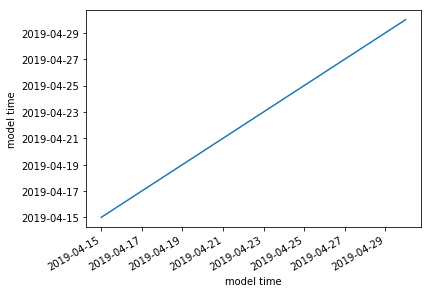

In [8]:
ds_truth.time.load().plot()

In [9]:
# RMSE_thickness = {'ds_grid1':[], 'ds_grid3':[], 'ds_grid7':[], 'ds_grid15':[]}

# for i in range(1, len(ds_truth.time)):
i = 45 #32 for the weird october cases #days = len(ds_FBgrid.time[0:i])
# x1 = ds_free.hi.isel(time=slice(0,i))
# x3 = ds_grid3.hi.isel(time=slice(0,i))
# x7 = ds_grid7.hi.isel(time=slice(0,i))
x15 = ds_grid15.hi.isel(time=slice(0,i))
i15 = ds_itd15.hi.isel(time=slice(0,i))
# s15 = ds_spring15.hi.isel(time=slice(0,i))
xx = ds_free.hi.isel(time=slice(0,i))
# y = ds_truth.hi.isel(time=slice(0,i))
ys = ds_truth.hi.isel(time=slice(0,i))

In [10]:
x15

<xarray.DataArray 'hi' (time: 45, nj: 384, ni: 320)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.98253286, 0.66799754, 0.6070685 , ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [1.0106655 , 0.69577444, 0.62162226, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [1.6254122 , 1.0796742 , 0.909292  , ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
    TLON     (nj, ni) float32 320.5625 321.6875 322.8125 ... 319.35068 319.7835
    TLAT     (nj, ni) float32 -79.22052 -79.22052 ... 72.18933 72.185974
    ULON     (nj, ni) float32 321.125 322.25 323.375 ... 319.58603 320.0
    ULAT     (nj, ni) float32 -78.952896 -78.952896 ... 72.41355 72.411934
  * time     (time) object 2019-04-15 00:00:00 ... 2019-05-29 00:00:00
Dimensions without coordinates: nj, ni
Attributes:
    units:          m
    long_name:      grid cell mean ice thickness
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [10]:
# thing = xs.rmse(x1, y, dim = 'time') 
# thing2 = xs.rmse(x2, y, dim = 'time')
# ds_truth.time.load()
# s15.load()
# i = 260
# norm = len(ds_truth.time[0:i])
norms = len(ds_truth.time[0:i])
# thing = metrics.mean_squared_error(y, x1, sample_weight=None, multioutput='uniform_average', squared=False)
    
# thing1 = np.sqrt(sum((x1 - y)**2)/norm) #
# thing3 = np.sqrt(sum((x3 - y)**2)/norm)
# thing7 = np.sqrt(sum((x7 - y)**2)/norm)
thing15 =  np.sqrt(sum((x15 - ys)**2)/norms)
thingi15 = np.sqrt(sum((i15 - ys)**2)/norms)
# thing15s = np.sqrt(sum((s15 - ys)**2)/norms)
thingT =   np.sqrt(sum((xx - ys)**2)/norms)
    
#     RMSE_thickness["ds_grid1"].append(thing1)
#     RMSE_thickness["ds_grid3"].append(thing3)
#     RMSE_thickness["ds_grid7"].append(thing7)
#     RMSE_thickness["ds_grid15"].append(thing15)
    

# RMSE= xr.concat(RMSE_thickness, dim='time') 

KeyboardInterrupt: 

### MAB

In [43]:
MAB_free = sum((ds_free.hi - ds_truth.hi))/len(ds_truth)
# MAB_dfb = sum(xr.ufuncs.fabs(ds_dass.aice - ds_truth.aice)/len(ds_truth))
# MAB_dth = sum(xr.ufuncs.fabs(ds_noise.aice - ds_truth.aice)/len(ds_truth))


# x3 = ds_dass.aice
# y1 = ds_truth.aice
# RMSE_dass = np.sqrt(sum((x3- y1)**2)/len(y1))

# SUB = RMSE_dass - MAB_dfb

In [ ]:
SUB.load()

/glade/work/mollyw/mmw_npl/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Text(0.5, 0.98, 'Fall Mean SIT Bias, FREE vs Mem24')

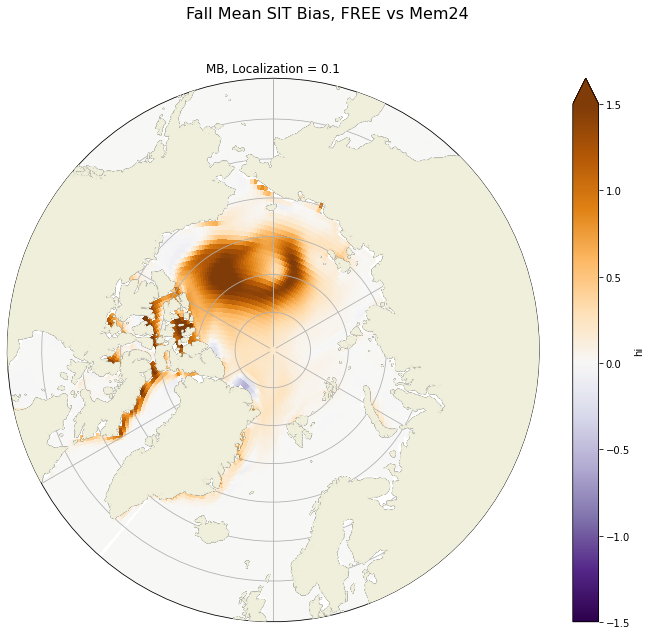

In [45]:
f=plt.figure(figsize=(12,10))
# for t in ds_free.time[::15]:
# nj=slice(280,ds_slfr.nj.size)
onPOPgrid=MAB_free
grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')
    
onPOPgrid.ULAT[:]=grid.lat
onPOPgrid.ULON[:]=grid.lon
#     onPOP1D=onPOPgrid.stack(n_s=('nj','ni'))
#     ongrid2=numpy.zeros(Ntot)
#     ongrid2[dst]=numpy.multiply(Tr.S.values,onPOP1D[src].values)
#     with numpy.errstate(divide='ignore', invalid='ignore'):
#         ongrid2=numpy.divide(ongrid2,totwts)
#     onPMgrid=numpy.reshape(ongrid2,(Tr.dst_grid_dims[1].values,Tr.dst_grid_dims[0].values))
    
    
#     tmp=numpy.flipud(onPMgrid.T)
#     # the land is nan which by default has color of zero so change it to a large negative 
#     tmp[numpy.isnan(tmp)]=-999.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

ax=plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=6)
    
onPOPgrid.plot.pcolormesh('ULON', 'ULAT', ax=ax, vmin = -1.5, vmax = 1.5, transform=ccrs.PlateCarree(), cmap=plt.cm.PuOr_r) #vmax = 0.05,
#     hnd=plt.pcolor(tmp, vmin=-.2, vmax=.2, cmap=plt.cm.seismic)
#     plt.ylim([110, 330])
# xr.plot.scatter(track, x = 'lon', y = 'lat', c = 'k', transform = ccrs.PlateCarree())  # vmin = 0, vmax = 0.1,
# xr.plot.scatter(track_ni200, x = 'lon', y = 'lat', c = 'k',  transform = ccrs.PlateCarree())
# xr.plot.scatter(track_circle, x = 'lon', y = 'lat', c = 'k', transform = ccrs.PlateCarree())
plt.title('MB, Localization = 0.1')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False,labelleft=False) # labels along the bottom edge are off
plt.suptitle('Fall Mean SIT Bias, FREE vs Mem24',fontsize =16)
# plt.tight_layout()
   


### RMSE

In [ ]:
fig = plt.figure(figsize = (8,6))
plt.plot(RMSE_fr,'--', linewidth = 2, label = 'freeboard')
plt.plot(RMSE_th,'--', linewidth = 2, label = 'thickness')
# plt.scatter(ds_dass.time, ds_dass.RMSE, 'k+')
plt.title("Spatial Mean RMSE", fontsize = 16)
plt.ylabel('RMSE')
plt.xlabel('# of days after assimilation')
# plt.ylim([0.017, 0.021])
plt.legend()

In [ ]:
track = track.where(track.freeboard > 0)
track_noisy = track_noisy.where(track_noisy.thickness > 0)

In [20]:
ds_free.isel(time=45)

<xarray.Dataset>
Dimensions:      (d2: 2, nc: 5, ni: 320, nj: 384, nkbio: 5, nkice: 8, nksnow: 3, nvertices: 4)
Coordinates:
    TLON         (nj, ni) float32 320.5625 321.6875 ... 319.35068 319.7835
    TLAT         (nj, ni) float32 -79.22052 -79.22052 ... 72.18933 72.185974
    ULON         (nj, ni) float32 320.5625 321.6875 ... 9.96921e+36 9.96921e+36
    ULAT         (nj, ni) float32 -79.22052 -79.22052 ... 9.96921e+36
    time         object 2019-05-30 00:00:00
Dimensions without coordinates: d2, nc, ni, nj, nkbio, nkice, nksnow, nvertices
Data variables:
    NCAT         (nc) float32 0.6445072 1.3914335 2.4701793 4.567288 100000000.0
    VGRDi        (nkice) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
    VGRDs        (nksnow) float32 1.0 2.0 3.0
    VGRDb        (nkbio) float32 1.0 2.0 3.0 4.0 5.0
    tmask        (nj, ni) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    tarea        (nj, ni) float32 1423619100.0 1423619100.0 ... 743223000.0
    uarea        (nj, ni) float32 1423489400.0 1423489400.0 ... 701017800.0
    dxt          (nj, ni) float32 23968.484 23968.484 ... 14724.672 14729.54
    dyt          (nj, ni) float32 59395.453 59395.453 ... 50464.47 50457.99
    dxu          (nj, ni) float32 23966.3 23966.3 ... 13905.831 13908.182
    dyu          (nj, ni) float32 59395.453 59395.453 ... 50406.527 50403.266
    HTN          (nj, ni) float32 23966.3 23966.3 ... 13903.4795 13908.182
    HTE          (nj, ni) float32 59395.453 59395.453 ... 50459.61 50456.367
    ANGLE        (nj, ni) float32 0.0 0.0 0.0 ... -0.025899798 2.8036368e-07
    ANGLET       (nj, ni) float32 0.0 0.0 0.0 ... -0.038047884 -0.012683415
    lont_bounds  (nj, ni, nvertices) float32 320.0 321.125 ... 320.0 319.58603
    latt_bounds  (nj, ni, nvertices) float32 -79.48714 -79.48714 ... 72.41355
    lonu_bounds  (nj, ni, nvertices) float32 320.5625 321.6875 ... 319.8016
    latu_bounds  (nj, ni, nvertices) float32 -79.22052 -79.22052 ... 72.63671
    time_bounds  (d2) object 2019-05-29 00:00:00 2019-05-30 00:00:00
    hi           (nj, ni) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    title:             free30
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  day_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 20150102
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           Tue Sep 15 12:45:40 2020: ncea free30.cice_0001.h.2015...
    io_flavor:         io_pio
    NCO:               netCDF Operators version 4.7.9 (Homepage = http://nco....

/glade/work/mollyw/mmw_npl/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Text(0.5, 0.98, 'Spring Thickness OSSE, Day 45, Tracks = 15')

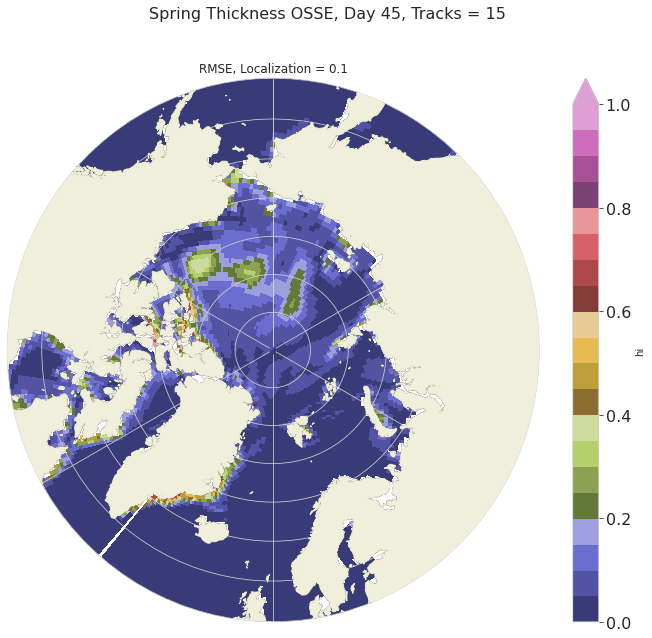

In [14]:
f=plt.figure(figsize=(12,10))
# for t in ds_free.time[::15]:
# nj=slice(280,ds_slfr.nj.size)
onPOPgrid=thingi15
grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')
    
onPOPgrid.ULAT[:]=grid.lat
onPOPgrid.ULON[:]=grid.lon
#     onPOP1D=onPOPgrid.stack(n_s=('nj','ni'))
#     ongrid2=numpy.zeros(Ntot)
#     ongrid2[dst]=numpy.multiply(Tr.S.values,onPOP1D[src].values)
#     with numpy.errstate(divide='ignore', invalid='ignore'):
#         ongrid2=numpy.divide(ongrid2,totwts)
#     onPMgrid=numpy.reshape(ongrid2,(Tr.dst_grid_dims[1].values,Tr.dst_grid_dims[0].values))
    
    
#     tmp=numpy.flipud(onPMgrid.T)
#     # the land is nan which by default has color of zero so change it to a large negative 
#     tmp[numpy.isnan(tmp)]=-999.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

ax=plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=6)
    
onPOPgrid.plot.pcolormesh('ULON', 'ULAT', ax=ax,vmin = 0, vmax = 1, transform=ccrs.PlateCarree(), cmap=plt.cm.tab20b) #vmin = 0, vmax = 1vmin = -1, vmax = 1
#     hnd=plt.pcolor(tmp, vmin=-.2, vmax=.2, cmap=plt.cm.seismic)
#     plt.ylim([110, 330])
# xr.plot.scatter(track_ni200, x = 'lon', y = 'lat', hue = 'freeboard', vmin = 0, vmax = 0.1, transform = ccrs.PlateCarree(), cmap = cm.Blues_r)
plt.title('RMSE, Localization = 0.1')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False,labelleft=False) # labels along the bottom edge are off
plt.suptitle('Spring Thickness OSSE, Day ' + str(i) + ', Tracks = ' + str(15),fontsize =16)
# plt.tight_layout()
   


In [28]:
ds_truth.load()

<xarray.Dataset>
Dimensions:      (d2: 2, nc: 5, ni: 320, nj: 384, nkbio: 5, nkice: 8, nksnow: 3, nvertices: 4, time: 78)
Coordinates:
  * time         (time) object 2019-04-15 00:00:00 ... 2019-07-01 00:00:00
    TLON         (nj, ni) float32 320.5625 321.6875 ... 319.35068 319.7835
    TLAT         (nj, ni) float32 -79.22052 -79.22052 ... 72.18933 72.185974
    ULON         (nj, ni) float32 321.125 322.25 323.375 ... 319.58603 320.0
    ULAT         (nj, ni) float32 -78.952896 -78.952896 ... 72.41355 72.411934
    NCAT         (nc) float32 0.6445072 1.3914335 2.4701793 4.567288 100000000.0
Dimensions without coordinates: d2, nc, ni, nj, nkbio, nkice, nksnow, nvertices
Data variables:
    time_bounds  (time, d2) object 2019-04-14 00:00:00 ... 2019-07-01 00:00:00
    VGRDi        (time, nkice) float32 1.0 2.0 3.0 4.0 5.0 ... 5.0 6.0 7.0 8.0
    VGRDs        (time, nksnow) float32 1.0 2.0 3.0 1.0 2.0 ... 3.0 1.0 2.0 3.0
    VGRDb        (time, nkbio) float32 1.0 2.0 3.0 4.0 5.0 ... 2.0 3.0 4.0 5.0
    tmask        (time, nj, ni) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tarea        (time, nj, ni) float32 1423619100.0 ... 743223000.0
    uarea        (time, nj, ni) float32 1423489400.0 ... 701017800.0
    dxt          (time, nj, ni) float32 23968.484 23968.484 ... 14729.54
    dyt          (time, nj, ni) float32 59395.453 59395.453 ... 50457.99
    dxu          (time, nj, ni) float32 23966.3 23966.3 ... 13905.831 13908.182
    dyu          (time, nj, ni) float32 59395.453 59395.453 ... 50403.266
    HTN          (time, nj, ni) float32 23966.3 23966.3 ... 13903.4795 13908.182
    HTE          (time, nj, ni) float32 59395.453 59395.453 ... 50456.367
    ANGLE        (time, nj, ni) float32 0.0 0.0 ... -0.025899798 2.8036368e-07
    ANGLET       (time, nj, ni) float32 0.0 0.0 ... -0.038047884 -0.012683415
    lont_bounds  (time, nj, ni, nvertices) float32 320.0 321.125 ... 319.58603
    latt_bounds  (time, nj, ni, nvertices) float32 -79.48714 ... 72.41355
    lonu_bounds  (time, nj, ni, nvertices) float32 320.5625 ... 319.8016
    latu_bounds  (time, nj, ni, nvertices) float32 -79.22052 ... 72.63671
    hi           (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    hs           (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    snowfrac     (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    aice         (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    fswdn        (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    sst          (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    sss          (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    frzmlt       (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    fswabs       (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    albsni       (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    albice       (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    albsno       (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    albpnd       (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    congel       (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    frazil       (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    meltt        (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    melts        (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    meltb        (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    meltl        (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    fswthru      (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    dvidtt       (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    dvidtd       (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    daidtt       (time, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    daidtd       (

/glade/work/mollyw/mmw_npl/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/mollyw/mmw_npl/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


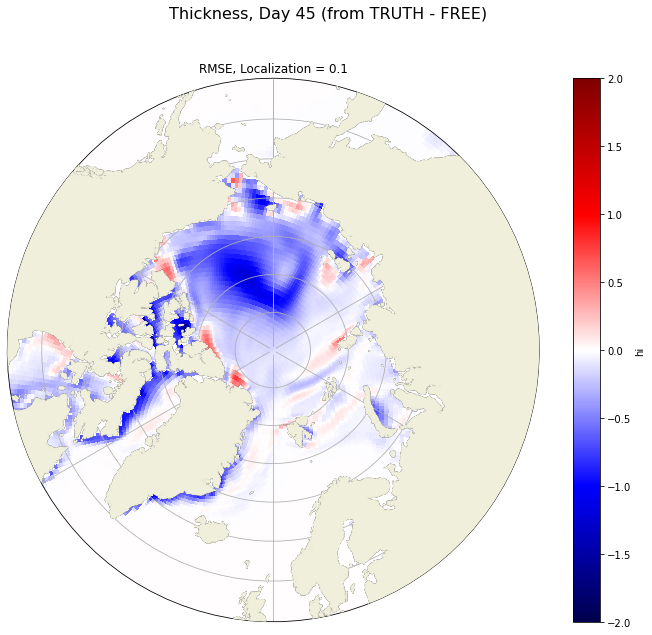

In [35]:
f=plt.figure(figsize=(12,10))
# for t in ds_free.time[::15]:
# nj=slice(280,ds_slfr.nj.size)
onPOPgrid=ds_truth.hi.isel(time=45) - ds_free.hi.isel(time=45)
grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')
    
onPOPgrid.ULAT[:]=grid.lat
onPOPgrid.ULON[:]=grid.lon
#     onPOP1D=onPOPgrid.stack(n_s=('nj','ni'))
#     ongrid2=numpy.zeros(Ntot)
#     ongrid2[dst]=numpy.multiply(Tr.S.values,onPOP1D[src].values)
#     with numpy.errstate(divide='ignore', invalid='ignore'):
#         ongrid2=numpy.divide(ongrid2,totwts)
#     onPMgrid=numpy.reshape(ongrid2,(Tr.dst_grid_dims[1].values,Tr.dst_grid_dims[0].values))
    
    
#     tmp=numpy.flipud(onPMgrid.T)
#     # the land is nan which by default has color of zero so change it to a large negative 
#     tmp[numpy.isnan(tmp)]=-999.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

ax=plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=6)
    
onPOPgrid.plot.pcolormesh('ULON', 'ULAT',vmin = -2 , vmax = 2, ax=ax, transform=ccrs.PlateCarree(), cmap=plt.cm.seismic) #vmax = 0.05,
#     hnd=plt.pcolor(tmp, vmin=-.2, vmax=.2, cmap=plt.cm.seismic)
#     plt.ylim([110, 330])
# xr.plot.scatter(track_ni200_th, x = 'lon', y = 'lat', hue = 'thickness', vmin = 0, vmax = 3, ax = ax, transform = ccrs.PlateCarree(), cmap = cm.Blues_r)
plt.title('RMSE, Localization = 0.1')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False,labelleft=False) # labels along the bottom edge are off

plt.suptitle('Thickness, Day '  + str(i) + ' (from TRUTH - FREE)' ,fontsize =16)
plt.tight_layout()

In [ ]:
f=plt.figure(figsize=(12,10))
# for t in ds_free.time[::15]:
# nj=slice(280,ds_slfr.nj.size)
onPOPgrid=thing2-thing
grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')
    
onPOPgrid.ULAT[:]=grid.lat
onPOPgrid.ULON[:]=grid.lon
#     onPOP1D=onPOPgrid.stack(n_s=('nj','ni'))
#     ongrid2=numpy.zeros(Ntot)
#     ongrid2[dst]=numpy.multiply(Tr.S.values,onPOP1D[src].values)
#     with numpy.errstate(divide='ignore', invalid='ignore'):
#         ongrid2=numpy.divide(ongrid2,totwts)
#     onPMgrid=numpy.reshape(ongrid2,(Tr.dst_grid_dims[1].values,Tr.dst_grid_dims[0].values))
    
    
#     tmp=numpy.flipud(onPMgrid.T)
#     # the land is nan which by default has color of zero so change it to a large negative 
#     tmp[numpy.isnan(tmp)]=-999.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

ax=plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=6)
    
onPOPgrid.plot.pcolormesh('ULON', 'ULAT', ax=ax, vmin = -0.5, vmax = 0.5, transform=ccrs.PlateCarree(), cmap=plt.cm.seismic) #vmax = 0.05,
#     hnd=plt.pcolor(tmp, vmin=-.2, vmax=.2, cmap=plt.cm.seismic)
#     plt.ylim([110, 330])
xr.plot.scatter(track_ni200, x = 'lon', y = 'lat', hue = 'freeboard', vmin = 0, vmax = 0.1, ax = ax, transform = ccrs.PlateCarree(), cmap = cm.Blues_r)
plt.title('Localization = 0.1')
plt.suptitle('RMSE: Freeboard vs Thickness', fontsize= 16)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False,labelleft=False) # labels along the bottom edge are off
   
plt.tight_layout()

# 3. Timescale Assimilation Cookie Sheets

In [ ]:
# Lots of work to be done here ... 

/glade/work/mollyw/mmw_npl/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/mollyw/mmw_npl/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


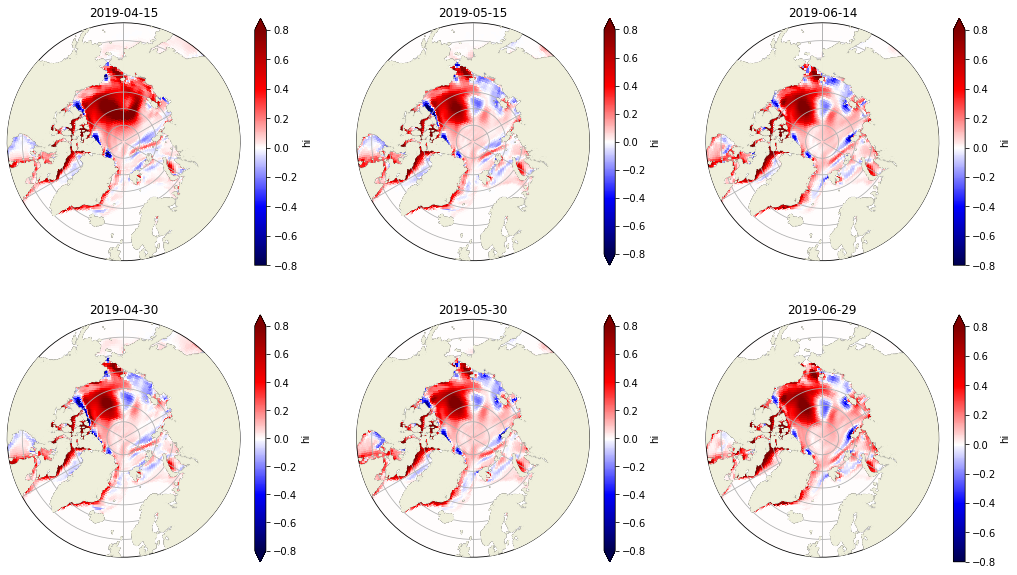

In [16]:
# Ensemble means
# Now plot differences of the DA run minus the free run
# in a loop to do it every 15 days, starting a few days after the first DA step
f=plt.figure(figsize=(24,10))
gs=GridSpec(2,4)
counter=0
grid1=0
grid2=0
grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')
for t in ds_grid1.time[::15]:
# nj=slice(280,ds_slfr.nj.size)
    onPOPgrid=ds_grid1.hi.sel(time=t)-ds_truth.hi.sel(time=t)
    
    onPOPgrid.TLAT[:]=grid.lat
    onPOPgrid.TLON[:]=grid.lon
    
    if counter/2 == grid2+1:
        grid2 = grid2+1
        grid1 = 0

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = matplotlib.path.Path(verts * radius + center)

    ax=plt.subplot(gs[grid1,grid2], projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
    ax.gridlines()
    ax.coastlines()
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.LAND,zorder=6)
    
    onPOPgrid.plot.pcolormesh('TLON', 'TLAT', ax=ax, vmin = -0.8, vmax = 0.8,transform=ccrs.PlateCarree(), cmap=plt.cm.seismic)
#     xr.plot.scatter(track, x = 'lon', y = 'lat', hue = 'freeboard', vmin = 0, vmax = 0.8, ax = ax, transform = ccrs.PlateCarree(), cmap = cm.Blues)
#     hnd=plt.pcolor(tmp, vmin=-.2, vmax=.2, cmap=plt.cm.seismic)
#     plt.ylim([110, 330])
    newt=str(t.values)
    plt.title(newt[0:10])
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelbottom=False,labelleft=False) # labels along the bottom edge are off
        
    counter=counter+1
    grid1=grid1+1

plt.tight_layout()
# plt.colorbar()    


Text(0.5, 1.0, 'Along-track mean SIT, fall forecast')

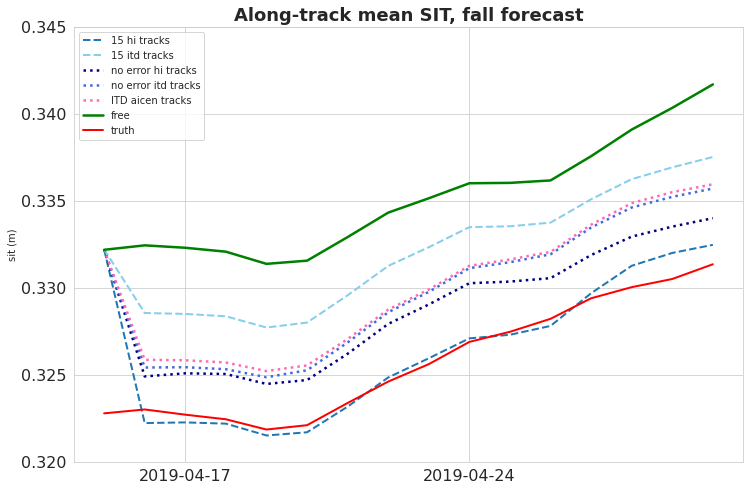

In [12]:
fig = plt.figure(figsize = (12,8)) 
# plt.plot(ds_grid1.time, ds_grid1.hi.sel(ni = 205).mean(dim='nj'),'--', linewidth = 2, label = '1 track') #.where(ds_FBgrid.hi > 1e-12)
# plt.plot(ds_grid3.time,ds_grid3.hi.sel(ni = 205).mean(dim ='nj'),'--', linewidth = 2, label= '3 tracks')
# plt.plot(ds_grid7.time,ds_grid7.hi.sel(ni = 205).mean(dim='nj'),'--', linewidth = 2, label= '7 tracks')
plt.plot(ds_free.time, ds_grid15.hi.sel(ni = 154).mean(dim='nj'),'--', linewidth = 2, label= '15 hi tracks')
plt.plot(ds_free.time, ds_itd15.hi.sel(ni = 154).mean(dim='nj'),'--', linewidth = 2, c = 'skyblue', label= '15 itd tracks')
plt.plot(ds_free.time, ds_grid15e2.hi.sel(ni = 154).mean(dim='nj'),linestyle='dotted', c = 'navy',linewidth = 2.5, label= 'no error hi tracks')
plt.plot(ds_free.time, ds_itd15e2.hi.sel(ni = 154).mean(dim='nj'), linestyle='dotted', c = 'royalblue',linewidth = 2.5, label= 'no error itd tracks')
plt.plot(ds_free.time, ds_itd15conc.hi.sel(ni = 154).mean(dim='nj'), linestyle='dotted', c = 'hotpink',linewidth = 2.5, label= 'ITD aicen tracks')
plt.plot(ds_free.time, ds_free.hi.sel(ni = 154).mean(dim='nj'), linewidth = 2.5, c = 'green', label = 'free')
plt.plot(ds_truth.time,ds_truth.hi.sel(ni = 154).mean(dim = 'nj'), linewidth = 2, c = 'red',  label = 'truth')
plt.ylabel('sit (m)')
plt.ylim((0.32, 0.345))
plt.legend()
plt.title('Along-track mean SIT, fall forecast',fontsize = 18, fontweight='bold')

In [10]:
import seaborn
import nc_time_axis

ModuleNotFoundError: No module named 'nc_time_axis'

Text(0.5, 1.0, 'Spatial mean SIT, fall forecast')

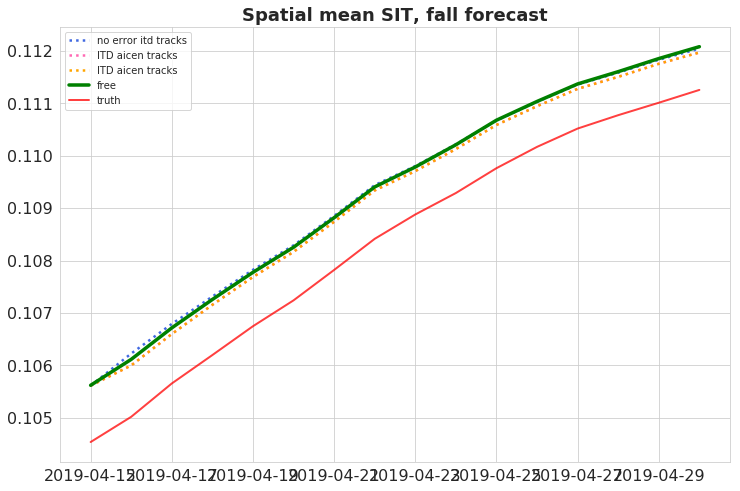

In [27]:
fig = plt.figure(figsize = (12,8)) 
seaborn.set_style("whitegrid")
seaborn.despine(left=True)
# plt.plot(ds_grid1.time, ds_grid1.hi.mean(dim=['ni','nj']),'--', linewidth = 2, label = '1 track')
# plt.plot(ds_grid3.time,ds_grid3.hi.mean(dim=['ni','nj']),'--', linewidth = 2, label= '3 tracks')
# plt.plot(ds_grid7.time,ds_grid7.hi.mean(dim=['ni','nj']),'--', linewidth = 2, label= '7 tracks')
# ds_grid15.hi.mean(dim=['ni','nj']).plot(x='time',linestyle='dashed', linewidth = 3, label= '15 tracks')
# ds_free.hi.mean(dim=['ni','nj']).plot(x='time',c='green', linewidth = 3.5, label= 'free')
# ds_truth.hi.mean(dim=['ni','nj']).plot(x='time',c='red', linewidth = 2, label= 'truth')
# plt.plot(ds_free.time, ds_grid15.hi.mean(dim=['ni','nj']),'--',linewidth = 2, label= '15 hi tracks')
# plt.plot(ds_free.time, ds_itd15.hi.mean(dim=['ni','nj']), '--',c = 'skyblue',linewidth = 2, label= '15 itd tracks')
# plt.plot(ds_free.time, ds_grid15e1.hi.mean(dim=['ni','nj']),'-.', c = 'dodgerblue',linewidth = 2.5, label= 'no noise hi tracks')
# plt.plot(ds_free.time, ds_itd15e1.hi.mean(dim=['ni','nj']), '-.', c = 'teal',linewidth = 2.5, label= 'no noise itd tracks')
# plt.plot(ds_free.time, ds_grid15e2.hi.mean(dim=['ni','nj']),linestyle='dotted', c = 'navy',linewidth = 2.5, label= 'no error hi tracks')
# plt.plot(ds_free.time, ds_itd15e2.hi.mean(dim=['ni','nj']), linestyle='dotted', c = 'royalblue',linewidth = 2.5, label= 'no error itd tracks')
# plt.plot(ds_free.time, ds_itd15conc.hi.mean(dim=['ni','nj']), linestyle='dotted', c = 'hotpink',linewidth = 2.5, label= 'ITD aicen tracks')
plt.plot(ds_free.time, ds_MAT.aice.mean(dim=['ni','nj']), linestyle='dotted', c = 'royalblue',linewidth = 2.5, label= 'no error itd tracks')
plt.plot(ds_free.time, ds_ITD.aice.mean(dim=['ni','nj']), linestyle='dotted', c = 'hotpink',linewidth = 2.5, label= 'ITD aicen tracks')
plt.plot(ds_free.time, ds_aITD.aice.mean(dim=['ni','nj']), linestyle='dotted', c = 'orange',linewidth = 2.5, label= 'ITD aicen tracks')

plt.plot(ds_free.time, ds_free.aice.mean(dim=['ni','nj']), c = 'green', linewidth = 3.5, label = 'free')
plt.plot(ds_free.time, ds_truth.aice.mean(dim=['ni','nj']), c = 'red', linewidth = 2, alpha = 0.75, label = 'truth')
# plt.ylabel('sit (m)', fontsize=16)
# plt.xticks([4, 5, 6, 7, 8, 9, 10, 11, 12])
# plt.ylim((0.15, 0.21))
# plt.xlim((ds_truth.time[0], ds_truth.time[-1]))
plt.legend()
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)
plt.grid(True)
plt.title('Spatial mean SIT, fall forecast',fontsize = 18,fontweight='bold')

### OLD CODE

In [ ]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  numpy.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*numpy.sqrt(n-2)/numpy.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

In [ ]:
a, b, mar_regs, c, d, i = lag_linregress_3D(ds_march_area.aice*100, ds_march_area.hi)
e, f, sep_regs, g, h, j = lag_linregress_3D(ds_sept_area.aice*100, ds_sept_area.hi)

In [ ]:
mar_regs.load()
sep_regs.load()

grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')


mar_regs.TLAT[:] = grid.lat
mar_regs.TLON[:] = grid.lon

sep_regs.TLAT[:] = grid.lat
sep_regs.TLON[:] = grid.lon

In [ ]:
ds_march_area = ds_march.where(ds_march.aice > 0.15)
ds_sept_area = ds_sept.where(ds_sept.aice > 0.15)

In [ ]:
mar_sig = d
sep_sig = h

mar_inds = mar_sig.TLAT.where(mar_sig < 0.05)
sep_inds = sep_sig.TLAT.where(mar_sig < 0.05)

In [ ]:
theta = numpy.linspace(0, 2*numpy.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = numpy.vstack([numpy.sin(theta), numpy.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

fig= plt.figure(figsize=(20,8))
ax1 = plt.subplot(1,2,1,projection=ccrs.NorthPolarStereo())
ax1.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax1.set_boundary(circle, transform=ax1.transAxes)
ax1.gridlines()
ax1.coastlines()
#ax1.add_feature(cfeature.LAND,zorder=6)
mar_regs.plot.pcolormesh('TLON','TLAT', transform=ccrs.PlateCarree(), cmap = 'RdBu_r',vmin = -3, vmax = 3)#where(mar_regs.TLAT == mar_inds)
plt.title('march',fontsize=16, fontweight='bold')

ax2 = plt.subplot(1,2,2,projection=ccrs.NorthPolarStereo())
ax2.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax2.set_boundary(circle, transform=ax2.transAxes)
ax2.gridlines()
ax2.coastlines()
#ax2.add_feature(cfeature.LAND,zorder=6)
sep_regs.plot.pcolormesh('TLON','TLAT', transform=ccrs.PlateCarree(), cmap = 'RdBu_r', vmin = -3, vmax = 3) #where(sep_regs.TLAT == sep_inds).
plt.title('september', fontsize=16, fontweight='bold')

plt.suptitle('time dependent regression of sea-ice variables', fontweight='bold',fontsize=20)
theta = numpy.linspace(0, 2*numpy.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = numpy.vstack([numpy.sin(theta), numpy.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

fig= plt.figure(figsize=(20,8))
ax1 = plt.subplot(1,2,1,projection=ccrs.NorthPolarStereo())
ax1.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax1.set_boundary(circle, transform=ax1.transAxes)
ax1.gridlines()
ax1.coastlines()
#ax1.add_feature(cfeature.LAND,zorder=6)
mar_regs.plot.pcolormesh('TLON','TLAT', transform=ccrs.PlateCarree(), cmap = 'RdBu_r',vmin = -3, vmax = 3)#where(mar_regs.TLAT == mar_inds)
plt.title('march',fontsize=16, fontweight='bold')

ax2 = plt.subplot(1,2,2,projection=ccrs.NorthPolarStereo())
ax2.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax2.set_boundary(circle, transform=ax2.transAxes)
ax2.gridlines()
ax2.coastlines()
#ax2.add_feature(cfeature.LAND,zorder=6)
sep_regs.plot.pcolormesh('TLON','TLAT', transform=ccrs.PlateCarree(), cmap = 'RdBu_r', vmin = -3, vmax = 3) #where(sep_regs.TLAT == sep_inds).
plt.title('september', fontsize=16, fontweight='bold')

plt.suptitle('time dependent regression of sea-ice variables', fontweight='bold',fontsize=20)


In [ ]:
fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(1,2,1)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,  
    left=False,         # ticks along the top edge are off
    labelbottom=False)
c = ax1.pcolor(mar_regs.where(abs(mar_regs) < 1), cmap = 'RdBu')
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax2 = plt.subplot(1,2,2)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,  
    left=False,         # ticks along the top edge are off
    labelbottom=False)
c2 = ax2.pcolor(sep_regs.where(abs(sep_regs) < 1), cmap = 'RdBu')
ax2.set_yticklabels([])
ax2.set_xticklabels([])
plt.suptitle('time-varying correlation of sea ice variables', fontweight='bold',fontsize=16)
fig.colorbar(c, ax=ax1)
fig.colorbar(c2, ax=ax2)

In [ ]:
vol_case_nh=ds_case.hi.isel(nj=slice(350,380),ni=slice(110,220)).mean(dim=['nj','ni']).values #for time mean use this : isel(nj=slice(367,377),ni=slice(98,108)).mean(dim=['nj','ni'])
# vol_free_nh=ds_slfr.hi.isel(nj=slice(367,377),ni=slice(98,108)).mean(dim=['nj','ni']).values
vol_free_nh=ds_free.hi.isel(nj=slice(350,380),ni=slice(110,220)).mean(dim=['nj','ni']).values

# (367,377),ni=slice(98,108)

time = 1 #214 for b cases #261
#change to this once there is a noticeable time series
hnd=plt.scatter(time, vol_free_nh, time, vol_case_nh)#ds_free.time[::5],NHvolume2[::5],'.')

#plt.scatter(ds_case.TLAT.values,vol_free_nh, marker ='.')
#plt.scatter(ds_case.TLAT.values,vol_case_nh, marker ='.')
plt.legend(['Free Run','DA Run'])
plt.title('Northern Hemisphere Sea Ice Volume')
plt.xticks(rotation=50)
print('First assimilation step is at second green dot, check slices if no blue line.\nIf the lines are equal, check your slice.')

In [27]:
j = np.linspace(70, 280, 16)

In [28]:
j

array([ 70.,  84.,  98., 112., 126., 140., 154., 168., 182., 196., 210.,
       224., 238., 252., 266., 280.])

In [2]:
with open('experiment.p', 'rb') as fp:
    experiment1 = pickle.load(fp)

In [3]:
experiment1

{'MAT': <xarray.Dataset>
 Dimensions:      (d2: 2, nc: 5, ni: 320, nj: 384, nkbio: 5, nkice: 8, nksnow: 3, nvertices: 4, time: 16)
 Coordinates:
     TLON         (nj, ni) float32 ...
     TLAT         (nj, ni) float32 ...
     ULON         (nj, ni) float32 ...
     ULAT         (nj, ni) float32 ...
   * time         (time) datetime64[ns] 2019-04-15 2019-04-16 ... 2019-04-30
 Dimensions without coordinates: d2, nc, ni, nj, nkbio, nkice, nksnow, nvertices
 Data variables:
     NCAT         (nc) float32 ...
     VGRDi        (nkice) float32 ...
     VGRDs        (nksnow) float32 ...
     VGRDb        (nkbio) float32 ...
     tmask        (nj, ni) float32 ...
     tarea        (nj, ni) float32 ...
     uarea        (nj, ni) float32 ...
     dxt          (nj, ni) float32 ...
     dyt          (nj, ni) float32 ...
     dxu          (nj, ni) float32 ...
     dyu          (nj, ni) float32 ...
     HTN          (nj, ni) float32 ...
     HTE          (nj, ni) float32 ...
     ANGLE        (nj, 

In [2]:
grid1 = xr.open_dataset('/glade/work/mollyw/DART/observations/obs_converters/cice/data/perfect_itd_4_15.nc')
grid2 = xr.open_dataset('/glade/work/mollyw/DART/observations/obs_converters/cice/data/perfect_itd_4_15_nopert.nc')

In [3]:
grid1

<xarray.Dataset>
Dimensions:  (nc: 5, ni: 384, nj: 15, time: 1)
Coordinates:
    lon      (ni, nj) float32 ...
    lat      (ni, nj) float32 ...
  * time     (time) datetime64[ns] 2019-04-15
Dimensions without coordinates: nc, ni, nj
Data variables:
    aicen    (time, nc, ni, nj) float64 ...
Attributes:
    description:  itd track, osse

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

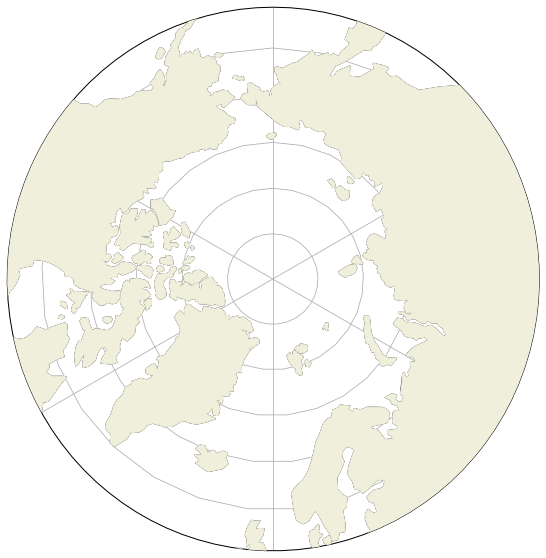

In [9]:
f=plt.figure(figsize=(12,10))
# for t in ds_free.time[::15]:
# nj=slice(280,ds_slfr.nj.size)
ONE=grid1.aicen.isel(nc=1)
TWO=grid2.aicen.isel(nc=1)

onPOPgrid = ONE-TWO
#     onPOP1D=onPOPgrid.stack(n_s=('nj','ni'))
#     ongrid2=numpy.zeros(Ntot)
#     ongrid2[dst]=numpy.multiply(Tr.S.values,onPOP1D[src].values)
#     with numpy.errstate(divide='ignore', invalid='ignore'):
#         ongrid2=numpy.divide(ongrid2,totwts)
#     onPMgrid=numpy.reshape(ongrid2,(Tr.dst_grid_dims[1].values,Tr.dst_grid_dims[0].values))
    
    
#     tmp=numpy.flipud(onPMgrid.T)
#     # the land is nan which by default has color of zero so change it to a large negative 
#     tmp[numpy.isnan(tmp)]=-999.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

ax=plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=6)
    
onPOPgrid.plot.pcolormesh('lon', 'lat',vmin = -2 , vmax = 2, ax=ax, transform=ccrs.PlateCarree(), cmap=plt.cm.seismic) #vmax = 0.05,
#     hnd=plt.pcolor(tmp, vmin=-.2, vmax=.2, cmap=plt.cm.seismic)
#     plt.ylim([110, 330])
# xr.plot.scatter(track_ni200_th, x = 'lon', y = 'lat', hue = 'thickness', vmin = 0, vmax = 3, ax = ax, transform = ccrs.PlateCarree(), cmap = cm.Blues_r)
plt.title('RMSE, Localization = 0.1')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False,labelleft=False) # labels along the bottom edge are off

plt.suptitle('Thickness, Day '  + str(i) + ' (from TRUTH - FREE)' ,fontsize =16)
plt.tight_layout()

In [6]:
ONE

<xarray.DataArray 'aicen' (time: 1, ni: 384, nj: 15)>
array([[[-888888., -888888., ..., -888888., -888888.],
        [-888888., -888888., ..., -888888., -888888.],
        ...,
        [-888888., -888888., ..., -888888., -888888.],
        [-888888., -888888., ..., -888888., -888888.]]])
Coordinates:
    lon      (ni, nj) float32 ...
    lat      (ni, nj) float32 ...
  * time     (time) datetime64[ns] 2019-04-15
Dimensions without coordinates: ni, nj

AttributeError: module 'xarray.plot' has no attribute 'scatter'

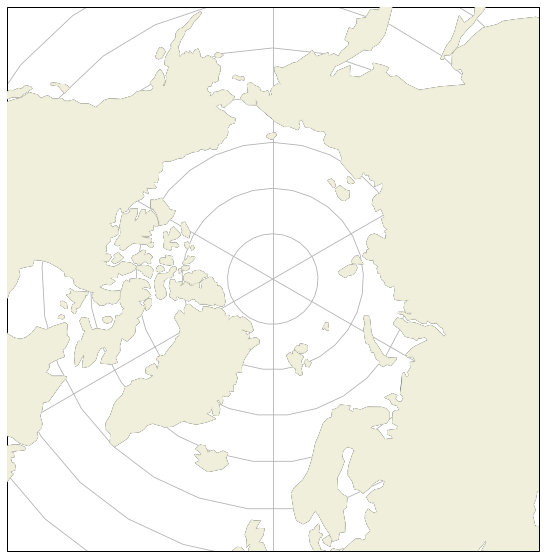

In [12]:
f=plt.figure(figsize=(12,10))
ax=plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
# ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=6)
# track.where(track.vicen > 0).sel(nc = 0).plot.scatter(cmap = 'bone', transform = ccrs.PlateCarree())
xr.plot.scatter(grid1.aicen, x = 'lon', y = 'lat', c = grid1.aicen.where(track.aicen > 0).sel(nc=4),vmin = 0, vmax = 8, transform = ccrs.PlateCarree())

In [6]:
free

<xarray.DataArray 'hi' (time: 15, nj: 384, ni: 320)>
[1843200 values with dtype=float32]
Coordinates:
    TLON     (nj, ni) float32 ...
    TLAT     (nj, ni) float32 ...
    ULON     (nj, ni) float32 ...
    ULAT     (nj, ni) float32 ...
  * time     (time) datetime64[ns] 2019-04-15 2019-04-16 ... 2019-04-29
Dimensions without coordinates: nj, ni
Attributes:
    units:          m
    long_name:      grid cell mean ice thickness
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged